<a href="https://colab.research.google.com/github/andressapedrosa/data_science_analytics/blob/main/An%C3%A1lise_S%C3%ADndrome_Respirat%C3%B3ria_Aguda_Grave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados relacionados a Síndrome Respiratória Aguda Grave (SRAG) no Brasil**

O escopo deste trabalho foca em **dados de saúde**, mais especificamente em registros de notificações de casos de Síndrome Respiratória Aguda Grave. <br/>

Estas notificações podem ser utilizadas pela Secretaria de Vigilância em Saúde para mapeamento dos casos e auxiliar na tomada de decisões para escolhas de tratamentos e prevenções na área da saúde. <br/>

Uma das informações disponíveis neste conjunto de dados trata do '**Diagnóstico Final do Caso**'. Trata-se de uma variável categórica que informa se o Paciente foi infectado com o vírus do Covid ou Influenza (gripe).<br/>
Assumindo como premissa que esta informação é a variável target e utilizando features relacionadas ao perfil do Paciente, sintomas, vacina e resultado de exames, entende-se que estamos lidando com um **problema de aprendizagem supervisionado de Classificação**. <br/>

A fonte de dados utilizada neste trabalho é do tipo 'dados abertos' e pode ser acessível em:
* https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024

Este dataset possui mais de 190 colunas, porém nem todas serão utilizadas ao longo da análise (mais detalhes ao longo do notebook).Abaixo estão descritas as variáveis utilizadas :


COLUNA             | DESCRIÇÃO
-------------------|------------------
ID_UNIDADE | Unidade que realizou o atendimento, coleta de amostra e registro do caso.
CS_SEXO | Sexo do paciente
NU_IDADE_N | Idade do paciente
TP_IDADE | Tipo da 'unidade de medida' da idade (pode ser em dias, meses ou anos)
CS_RACA | Raça do paciente
FEBRE | Sintoma: Paciente apresentou febre?
TOSSE | Sintoma: Paciente apresentou tosse?
GARGANTA | Sintoma: Paciente apresentou dor de garganta?
DISPNEIA | Sintoma: Paciente apresentou dispneia?
DESC_RESP | Sintoma: Paciente apresentou desconforto respiratório?
SATURACAO | Sintoma: Paciente apresentou saturação O2< 95%??
DIARREIA | Sintoma: Paciente apresentou diarreira?
VOMITO | Sintoma: Paciente apresentou vômito?
FATOR_RISC | Paciente apresenta algum fator de risco?
HOSPITAL | O paciente foi internado?
DT_INTERNA | Data da internação
SG_UF_INTE | Unidade Federativa de internação do paciente.
UTI | O paciente foi internado em UTI?
PCR_RESUL | Resultado do teste de RT-PC
CLASSI_FIN | Diagnóstico final do caso.
EVOLUCAO | Evolução do caso (indica se houve cura ou óbito)
DOR_ABD | Sintoma: Paciente apresentou dor abdominal?
FADIGA | Sintoma: Paciente apresentou fadiga?
PERD_OLFT | Sintoma: Paciente apresentou perda de olfato?
PERD_PALA | Sintoma: Paciente apresentou perda de paladar?
RES_AN | Resultado do Teste Antigênico
VACINA_COV | Indica se o paciente recebeu vacina COVID-19


## Importação de Bibliotecas e ajustes de configurações

In [69]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação de bibliotecas
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import missingno as ms # para tratamento de missings
from sklearn.preprocessing import MinMaxScaler # Transformações Numéricas (normalização)
from sklearn.preprocessing import LabelEncoder # Transformações Categóricas

from sklearn.model_selection import train_test_split

In [70]:
# Ajustes de configuração
pd.set_option('display.max_info_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Funções customizadas utilizadas durante a análise

In [71]:
def percentual_nulos_em_colunas(df):
  """Retorna o percentual de dados nulos para as colunas do dataframe informado
  como parâmetro.
  """
  # Calcular o percentual de valores nulos por coluna
  percentual_nulos = df.isnull().mean() * 100

  # Definir um nome para a série
  percentual_nulos.name = 'Percentual Nulos'

  # Ordenando pelas colunas com maior valor percentual de nulos
  percentual_nulos.sort_values(ascending=False, inplace=True)

  return percentual_nulos

def percentual_valores_unicos(df, coluna):
  """Retorna o percentual de valores únicos para a coluna informada como parâmetro.
  """
  return df[coluna].value_counts(dropna=False, normalize=True).mul(100).round(2)

def converte_idade_para_anos(linha, idade, unidade_medida):
    """Converte a idade para anos com base na unidade de medida."""
    if linha[unidade_medida] == 1:  # dias
        return linha[idade] / 365  # Aproximadamente 365 dias por ano
    elif linha[unidade_medida] == 2:  # meses
        return linha[idade] / 12  # 12 meses por ano
    elif linha[unidade_medida] == 3:  # anos
        return linha[idade]
    else:
        return None

def converte_raca_paciente(valor):
  """Retorna um dado categórico (raça) com base no valor numérico informado
  como parâmetro.
  """
  if valor == 1:
    return 'Branca'
  if valor == 2:
    return 'Preta'
  elif valor == 3:
    return 'Amarela'
  elif valor == 4:
      return 'Parda'
  elif valor == 5:
      return 'Indígena'
  elif valor == 9:
      return 'Ignorado'
  else:
      return valor

def converte_booleano(valor):
  """Retorna um dado categórico com base no valor numérico informado como
  parâmetro. Os dados de input podem ser: 1 para Sim, 2 para Não ou 9 para
  Ignorado
  """
  if valor == 1:
    return 'Sim'
  elif valor == 2:
    return 'Não'
  elif valor == 9:
      return 'Ignorado'
  else:
      return valor

def converte_resultado_pcr(valor):
  """Retorna um dado categórico com base no valor numérico informado como
  parâmetro. Os dados de input podem ser: 1 para 'Detectável', 2 para 'Não
  Detectável', 3 para 'Inconclusivo', 4 para 'Não Realizado', 5 para 'Aguardando
   Resultado' ou 9 para 'Ignorado'
  """
  if valor == 1:
    return 'Detectável'
  elif valor == 2:
    return 'Não Detectável'
  elif valor == 3:
      return 'Inconclusivo'
  elif valor == 4:
      return 'Não Realizado'
  elif valor == 5:
      return 'Aguardando Resultado'
  elif valor == 9:
      return 'Ignorado'
  else:
      return valor

def converte_descricao_diagnostico(valor):
  """Retorna um dado categórico com base no valor numérico informado como
  parâmetro. Os dados de input podem ser: 1 para 'SRAG por influenza', 2 para
  'SRAG por outro vírus respiratório', 3 para 'SRAG por outro agente
  etiológico', 4 para 'SRAG não especificado', 5 para 'SRAG por covid-19'
  """
  if valor == 1:
    return 'SRAG por influenza'
  elif valor == 2:
    return 'SRAG por outro vírus respiratório'
  elif valor == 3:
      return 'SRAG por outro agente etiológico'
  elif valor == 4:
      return 'SRAG não especificado'
  elif valor == 5:
      return 'SRAG por covid-19'
  else:
      return valor

def converte_descricao_evolucao(valor):
  """Retorna um dado categórico com base no valor numérico informado como
  parâmetro. Os dados de input podem ser: 1 para 'Cura', 2 para 'Óbito', 3 para
   'Óbito por outras causas' ou 9 para 'Ignorado'
  """
  if valor == 1:
    return 'Cura'
  elif valor == 2:
    return 'Óbito'
  elif valor == 3:
      return 'Óbito por outras causas'
  elif valor == 9:
      return 'Ignorado'
  else:
      return valor

def converte_resultado_teste_antigenico(valor):
  """Retorna um dado categórico com base no valor numérico informado como
  parâmetro. Os dados de input podem ser: 1 para 'Positivo', 2 para 'Negativo',
   3 para 'Inconclusivo', 4 para 'Não Realizado', 5 para 'Aguardando
   Resultado' ou 9 para 'Ignorado'
  """
  if valor == 1:
    return 'Positivo'
  elif valor == 2:
    return 'Negativo'
  elif valor == 3:
      return 'Inconclusivo'
  elif valor == 4:
      return 'Não Realizado'
  elif valor == 5:
      return 'Aguardando Resultado'
  elif valor == 9:
      return 'Ignorado'
  else:
      return valor

## Estruturas de Dicionário utilizadas ao longo da análise

Tratam-se de estruturas criadas para apoiar na criação de novas colunas que auxiliam na agregação dos dados para melhoria da análise.

In [72]:
# Dicionário para mapear números dos meses para nomes em português
meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

# Dicionário que mapeia os estados brasileiros para suas respectivas regiões
regioes_estados = {
    'AC': 'Norte',
    'AP': 'Norte',
    'AM': 'Norte',
    'PA': 'Norte',
    'RO': 'Norte',
    'RR': 'Norte',
    'TO': 'Norte',
    'AL': 'Nordeste',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'MA': 'Nordeste',
    'PB': 'Nordeste',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RN': 'Nordeste',
    'SE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'GO': 'Centro-Oeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'ES': 'Sudeste',
    'MG': 'Sudeste',
    'RJ': 'Sudeste',
    'SP': 'Sudeste',
    'PR': 'Sul',
    'RS': 'Sul',
    'SC': 'Sul'
}

## Carga dos Dados

In [73]:
# Carga do dataset

#url = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2024/INFLUD24-23-09-2024.csv"
url = "https://github.com/andressapedrosa/data_science_analytics/raw/refs/heads/main/INFLUD24-23-09-2024.zip"

df_sgra_original = pd.read_csv(url, delimiter=';', compression='zip')

## Análise Exploratória

### Informações Gerais e Estatísticas Descritivas

In [74]:
# Dimensões do dataset
df_sgra_original.shape

(199532, 191)

Através do comando '`shape`' podemos identificar que este dataset é composto por 191 colunas.
Abaixo utilizaremos o método '`info()`' para explorar os tipos de dados de cada coluna e quantidade de dados não nulos de cada uma delas.

In [75]:
df_sgra_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199532 entries, 0 to 199531
Data columns (total 191 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    DT_NOTIFIC  199532 non-null  object 
 1    SEM_NOT     199532 non-null  int64  
 2    DT_SIN_PRI  199532 non-null  object 
 3    SEM_PRI     199532 non-null  int64  
 4    SG_UF_NOT   199532 non-null  object 
 5    ID_REGIONA  175468 non-null  object 
 6    CO_REGIONA  175468 non-null  float64
 7    ID_MUNICIP  199532 non-null  object 
 8    CO_MUN_NOT  199532 non-null  int64  
 9    ID_UNIDADE  199532 non-null  object 
 10   CO_UNI_NOT  199532 non-null  int64  
 11   CS_SEXO     199532 non-null  object 
 12   DT_NASC     199473 non-null  object 
 13   NU_IDADE_N  199532 non-null  int64  
 14   TP_IDADE    199532 non-null  int64  
 15   COD_IDADE   199532 non-null  object 
 16   CS_GESTANT  199532 non-null  int64  
 17   CS_RACA     199532 non-null  int64  
 18   CS_ESCOL_N  124303 non

In [76]:
# Primeiros dados do dataset
df_sgra_original.head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,M_AMAMENTA,DT_DOSEUNI,DT_1_DOSE,DT_2_DOSE,ANTIVIRAL,TP_ANTIVIR,OUT_ANTIV,DT_ANTIVIR,HOSPITAL,DT_INTERNA,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE,UTI,DT_ENTUTI,DT_SAIDUTI,SUPORT_VEN,RAIOX_RES,RAIOX_OUT,DT_RAIOX,AMOSTRA,DT_COLETA,TP_AMOSTRA,OUT_AMOST,PCR_RESUL,DT_PCR,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,FLUASU_OUT,PCR_FLUBLI,FLUBLI_OUT,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DS_PCR_OUT,CLASSI_FIN,CLASSI_OUT,CRITERIO,EVOLUCAO,DT_EVOLUCA,DT_ENCERRA,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,FAB_COV_1,FAB_COV_2,FAB_COVREF,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,LOTE_REF,FNT_IN_COV,DOSE_2REF,FAB_COVRF2,LOTE_REF2,TRAT_COV,TIPO_TRAT,OUT_TRAT,DT_TRT_COV,CO_DETEC,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG,CASO_SRAG
0,05/01/2024,1,04/01/2024,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880,UPA CUMBICA,9400109,F,16/02/1997,26,3,3026,9,4,9.0,BRASIL,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,04/01/2024,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880.0,2.0,NaN,NaN,2.0,2.0,NaN,04/01/2024,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,9.0,NaN,05/01/2024,05/01/2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,05/01/2024,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11/08/2021,18/01/2022,08/02/2023,87 - COVID-19 PFIZER - COMIRNATY,87 - COVID-19 PFIZER - COMIRNATY,87 - COVID-19 PFIZER - COMIRNATY,87 - COVID-19 PFIZER - COMIRNATY,FF2591,FM2951,FX1188,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,11/01/2024,2,04/01/2024,1,GO,SUDOESTE II,1800.0,JATAI,521190,HOSPITAL PADRE TIAGO NA PROVIDENCIA DE DEUS,7532024,M,21/10/1951,72,3,3072,6,2,1.0,BRASIL,1,GO,SUDOESTE II,1800.0,JATAI,521190.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,2.0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,HAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,GO,SUDOESTE II,1800.0,JATAI,521190.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,11/01/2024,1.0,NaN,2.0,15/01/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,2.0,14/01/2024,16/01/2024,15/01/2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,1.0,NaN,NaN,2.0,11/01/2024,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10/01/2024,NaN,NaN,NaN,1.0,1.0,NaN,2.0,1.0,26/03/2021,23/04/2021,27/10/2021,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,87 - COVID-19 PFIZER - COMIRNATY,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,210060,210120,FG3531,2,06/05/2022,85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,21PVCD356Z,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,N

### Explorando Dados Nulos

Na célula a seguir é possível observar que existe uma quantidade considerável de colunas com alto percentual de valores nulos.

In [77]:
percentual_nulos_em_colunas(df_sgra_original)

,Percentual Nulos
PAIS_VGM,100.000000
VG_REINF,100.000000
TABAG,100.000000
CO_PS_VGM,100.000000
LO_PS_VGM,100.000000
DT_VGM,100.000000
DT_RT_VGM,100.000000
DT_TRT_COV,100.000000
VG_DTRES,100.000000
AN_PARA2,99.996492


### Escolha de um subset de colunas para a análise

A fim de criar uma análise mais sucinta e objetiva, serão selecionadas apenas algumas colunas de todo o dataset apresentado.
Seguem as regras adotadas:

*   serão removidas as colunas com mais de 70% dos valores nulos
*   considerando os pares de colunas do tipo 'código & descrição', serão removidos os códigos e mantidas somente as descrições
*   colunas que constam no dataframe, mas que não foram listadas no respectivo Dicionário de Dados serão removidas
*   colunas cujos conteúdos não são relevantes para a análise serão removidas



In [78]:
# Criando uma cópia do dataframe original
df_sgra = df_sgra_original

In [79]:
# Removendo colunas com mais de 70% dos valores nulos
limite_nulos = 0.7 * len(df_sgra)
df_sgra.dropna(thresh=limite_nulos, axis=1, inplace=True)

# Removendo do dataset as colunas que apresentam somente códigos (as respectivas colunas descritivas serão mantidas)
df_sgra.drop(columns=['CO_REGIONA', 'CO_MUN_NOT', 'CO_UNI_NOT', 'CO_PAIS', 'CO_RG_RESI', 'CO_MUN_RES', 'CO_MU_INTE'], inplace=True)

# Removendo do dataset as colunas que não estão descritas no Dicionário de Dados
df_sgra.drop(columns=['COD_IDADE', 'HISTO_VGM', 'REINF', 'CASO_SRAG', 'CO_RG_INTE'], inplace=True)

# Removendo do dataset colunas que não são relevantes para esta análise
df_sgra.drop(columns=['ID_MN_INTE'], inplace=True) # Município onde está localizado a Unidade de Saúde onde o paciente internou
df_sgra.drop(columns=['ID_MN_RESI'], inplace=True) # Município de residência do paciente.
df_sgra.drop(columns=['SG_UF'], inplace=True) # UF de residência do paciente.
df_sgra.drop(columns=['ID_PAIS'], inplace=True) # País de residência do paciente.
df_sgra.drop(columns=['SEM_NOT'], inplace=True) # Semana Epidemiológica do preenchimento da ficha de notificação
df_sgra.drop(columns=['SEM_PRI'], inplace=True) # Semana Epidemiológica dos Primeiros Sintomas
df_sgra.drop(columns=['ID_REGIONA'], inplace=True) # Regional de Saúde onde está localizado o Município realizou a notificação.
df_sgra.drop(columns=['AVE_SUINO'], inplace=True) # Caso com contato direto com aves ou suínos
df_sgra.drop(columns=['NOSOCOMIAL'], inplace=True) # Caso de SRAG com infecção adquirida após internação.
df_sgra.drop(columns=['OUTRO_SIN'], inplace=True) # Paciente apresentou outro(s) sintoma(s)?
df_sgra.drop(columns=['CS_GESTANT'], inplace=True) # Idade gestacional da paciente
df_sgra.drop(columns=['CS_ZONA'], inplace=True) # Zona geográfica do endereço de residência do paciente.
df_sgra.drop(columns=['SUPORT_VEN'], inplace=True) # O paciente fez uso de suporte ventilatório?
df_sgra.drop(columns=['CRITERIO'], inplace=True) # Indicar qual o critério de confirmação.
df_sgra.drop(columns=['DT_EVOLUCA'], inplace=True) # Data da alta ou óbito
df_sgra.drop(columns=['DT_ENCERRA'], inplace=True) # Data do encerramento do caso.
df_sgra.drop(columns=['DT_DIGITA'], inplace=True) # Data de inclusão do registro no sistema.
df_sgra.drop(columns=['FNT_IN_COV'], inplace=True) # Número gerado automaticamente pelo sistema
df_sgra.drop(columns=['ESTRANG'], inplace=True) # Informar se o paciente é estrangeiro
df_sgra.drop(columns=['DT_COLETA'], inplace=True) # Data da coleta da amostra para realização do teste diagnóstico
df_sgra.drop(columns=['TP_AMOSTRA'], inplace=True) # Tipo da amostra clínica coletada para o teste diagnóstico.
df_sgra.drop(columns=['DT_NASC'], inplace=True) # Data de nascimento do paciente (o campo idade está sempre preenchido, não sendo necessário manter a data de nascimento)
df_sgra.drop(columns=['ID_RG_RESI'], inplace=True) # Regional de Saúde onde está localizado o Município de residência do paciente
df_sgra.drop(columns=['ID_RG_INTE'], inplace=True) # Regional de Saúde onde está localizado o Município de internação do paciente.
df_sgra.drop(columns=['ID_MUNICIP'], inplace=True) # Município onde está localizada a Unidade que realizou a notificação.
df_sgra.drop(columns=['SG_UF_NOT'], inplace=True) # Unidade Federativa onde está localizada a Unidade que realizou a notificação
df_sgra.drop(columns=['DT_NOTIFIC'], inplace=True) # Data de preenchimento da ficha de notificação.
df_sgra.drop(columns=['ANTIVIRAL'], inplace=True) # Fez uso de antiviral para tratamento da gripe?
df_sgra.drop(columns=['AMOSTRA'], inplace=True) # Foi realizado coleta de amostra para realização de teste diagnóstico?
df_sgra.drop(columns=['DT_SIN_PRI'], inplace=True) # Data de 1º sintomas do caso.
df_sgra.drop(columns=['TRAT_COV'], inplace=True) # Fez uso de antiviral para tratamento de covid-19?

## Informações Gerais e Estatísticas Descritivas após a escolha do subset de colunas para a análise

In [80]:
# Dimensões do dataset
df_sgra.shape

(199532, 27)

Conseguimos diminuir em aproximadamente 86% a quantidade de colunas do dataframe: das 191 colunas originais, trabalharemos com 27 colunas ao longo da análise.

In [81]:
df_sgra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199532 entries, 0 to 199531
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_UNIDADE  199532 non-null  object 
 1   CS_SEXO     199532 non-null  object 
 2   NU_IDADE_N  199532 non-null  int64  
 3   TP_IDADE    199532 non-null  int64  
 4   CS_RACA     199532 non-null  int64  
 5   FEBRE       177218 non-null  float64
 6   TOSSE       185250 non-null  float64
 7   GARGANTA    148354 non-null  float64
 8   DISPNEIA    175569 non-null  float64
 9   DESC_RESP   173540 non-null  float64
 10  SATURACAO   167092 non-null  float64
 11  DIARREIA    148937 non-null  float64
 12  VOMITO      150331 non-null  float64
 13  FATOR_RISC  199532 non-null  int64  
 14  HOSPITAL    193660 non-null  float64
 15  DT_INTERNA  186271 non-null  object 
 16  SG_UF_INTE  181461 non-null  object 
 17  UTI         176518 non-null  float64
 18  PCR_RESUL   183582 non-null  float64
 19  CL

In [82]:
# Primeiros dados do dataset
df_sgra.head()

,ID_UNIDADE,CS_SEXO,NU_IDADE_N,TP_IDADE,CS_RACA,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,HOSPITAL,DT_INTERNA,SG_UF_INTE,UTI,PCR_RESUL,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV
0,UPA CUMBICA,F,26,3,4,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2,1.0,04/01/2024,SP,2.0,NaN,4.0,9.0,2.0,2.0,2.0,2.0,2.0,1.0
1,HOSPITAL PADRE TIAGO NA PROVIDENCIA DE DEUS,M,72,3,2,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1,1.0,NaN,GO,NaN,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
2,HOSPITAL GERAL DR WALDEMAR ALCANTARA,F,6,2,4,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2,1.0,22/01/2024,CE,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0
3,HOSPITAL INFANTIL DOUTOR WALDEMAR MONASTIER,M,6,2,1,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2,1.0,24/01/2024,PR,1.0,1.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
4,HOSPITAL ALVORADA DE BRASILIA,F,34,3,1,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2,1.0,17/01/2024,DF,2.0,NaN,5.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0


In [83]:
# Últimos dados do dataset
df_sgra.tail()

,ID_UNIDADE,CS_SEXO,NU_IDADE_N,TP_IDADE,CS_RACA,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,HOSPITAL,DT_INTERNA,SG_UF_INTE,UTI,PCR_RESUL,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV
199527,FUNDAJAN,M,5,3,4,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,1.0,17/08/2024,MG,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,4.0,2.0
199528,HOSPITAL E MATERNIDADE MARIA DE NAZARE,F,11,3,9,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1,1.0,01/09/2024,RJ,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0
199529,HOSPITAL SANTA GENOVEVA,M,96,3,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1,1.0,08/09/2024,MG,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,2.0
199530,HOSPITAL REGIONAL DO GUARA I,F,1,3,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2,1.0,25/08/2024,DF,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0
199531,HOSPITAL IRMAOS PENTEADO E SANTA CASA DE CAMPINAS,M,2,3,2,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,2,1.0,03/09/2024,SP,2.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0


### Transformação de dados

Com base nas informações citadas no Dicionário de Dados, faremos transformações para facilitar a análise e melhorar o entendimento dos dados.

In [84]:
# Ajustes de tipos de dados: alterando de 'object' para 'datetime'
df_sgra['DT_INTERNA'] = pd.to_datetime(df_sgra['DT_INTERNA'], format='%d/%m/%Y', errors='coerce')

In [85]:
# @title
# Transformando os dados relacionados a Raça do Paciente
df_sgra['CS_RACA'] = df_sgra['CS_RACA'].apply(converte_raca_paciente)

# Transformando os dados relacionados a ocorrência de FEBRE
df_sgra['FEBRE'] = df_sgra['FEBRE'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de TOSSE
df_sgra['TOSSE'] = df_sgra['TOSSE'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de dor na GARGANTA
df_sgra['GARGANTA'] = df_sgra['GARGANTA'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de DISPNEIA
df_sgra['DISPNEIA'] = df_sgra['DISPNEIA'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de Desconforto Respiratório
df_sgra['DESC_RESP'] = df_sgra['DESC_RESP'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de SATURACAO O2< 95%
df_sgra['SATURACAO'] = df_sgra['SATURACAO'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de DIARREIA
df_sgra['DIARREIA'] = df_sgra['DIARREIA'].apply(converte_booleano)

# Transformando os dados relacionados a ocorrência de VOMITO
df_sgra['VOMITO'] = df_sgra['VOMITO'].apply(converte_booleano)

# Transformando os dados relacionados a presença de fatores de risco
df_sgra['FATOR_RISC'] = df_sgra['FATOR_RISC'].apply(converte_booleano)

# Transformando os dados relacionados a presença de fatores de risco
df_sgra['HOSPITAL'] = df_sgra['HOSPITAL'].apply(converte_booleano)

# Transformando os dados relacionados a indicação de internamento do Paciente na UTI
df_sgra['UTI'] = df_sgra['UTI'].apply(converte_booleano)

# Transformando os dados relacionados a indicação se houve dor nas costas
df_sgra['DOR_ABD'] = df_sgra['DOR_ABD'].apply(converte_booleano)

# Transformando os dados relacionados a indicação se houve fadiga
df_sgra['FADIGA'] = df_sgra['FADIGA'].apply(converte_booleano)

# Transformando os dados relacionados a indicação se houve perda de olfato
df_sgra['PERD_OLFT'] = df_sgra['PERD_OLFT'].apply(converte_booleano)

# Transformando os dados relacionados a indicação se houve perda de paladar
df_sgra['PERD_PALA'] = df_sgra['PERD_PALA'].apply(converte_booleano)

# Transformando os dados relacionados a indicação se recebeu a vacina de Covid-19
df_sgra['VACINA_COV'] = df_sgra['VACINA_COV'].apply(converte_booleano)

# Transformando os dados sobre o resultado do exame PCR
df_sgra['PCR_RESUL'] = df_sgra['PCR_RESUL'].apply(converte_resultado_pcr)

# Transformando os dados sobre o diagnóstico final do caso
df_sgra['CLASSI_FIN'] = df_sgra['CLASSI_FIN'].apply(converte_descricao_diagnostico)

# Transformando os dados sobre a evolução final do caso
df_sgra['EVOLUCAO'] = df_sgra['EVOLUCAO'].apply(converte_descricao_evolucao)

# Transformando os dados sobre o resultado do teste de antígeno
df_sgra['RES_AN'] = df_sgra['RES_AN'].apply(converte_resultado_teste_antigenico)

# Transformando a idade do Paciente
# Para este caso será necessária a criação de uma nova coluna que representa a
# idade em anos. Será realizada a conversão da coluna que representa a idade
# (NU_IDADE_N) com base na coluna que representa o tipo da idade (TP_IDADE).
# TP_IDADE pode ser 1 (Dia), 2 (Mês) ou 3 (Ano)
df_sgra['NU_IDADE_ANO'] = df_sgra.apply(
    lambda linha: converte_idade_para_anos(linha, 'NU_IDADE_N', 'TP_IDADE'),
    axis = 1)

# Em seguida as colunas 'TP_IDADE' e 'NU_IDADE_N' podem ser removidas
df_sgra.drop(columns=['TP_IDADE', 'NU_IDADE_N'], inplace=True)

# Convertendo a coluna de idade de float para inteiro
df_sgra['NU_IDADE_ANO'] = df_sgra['NU_IDADE_ANO'].astype(int)

In [86]:
df_sgra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199532 entries, 0 to 199531
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID_UNIDADE    199532 non-null  object        
 1   CS_SEXO       199532 non-null  object        
 2   CS_RACA       199532 non-null  object        
 3   FEBRE         177218 non-null  object        
 4   TOSSE         185250 non-null  object        
 5   GARGANTA      148354 non-null  object        
 6   DISPNEIA      175569 non-null  object        
 7   DESC_RESP     173540 non-null  object        
 8   SATURACAO     167092 non-null  object        
 9   DIARREIA      148937 non-null  object        
 10  VOMITO        150331 non-null  object        
 11  FATOR_RISC    199532 non-null  object        
 12  HOSPITAL      193660 non-null  object        
 13  DT_INTERNA    186265 non-null  datetime64[ns]
 14  SG_UF_INTE    181461 non-null  object        
 15  UTI           176

In [87]:
# Primeiros dados do dataset
df_sgra.head()

,ID_UNIDADE,CS_SEXO,CS_RACA,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,HOSPITAL,DT_INTERNA,SG_UF_INTE,UTI,PCR_RESUL,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV,NU_IDADE_ANO
0,UPA CUMBICA,F,Parda,Sim,Sim,Não,Sim,Sim,Sim,Não,Não,Não,Sim,2024-01-04,SP,Não,NaN,SRAG não especificado,Ignorado,Não,Não,Não,Não,Negativo,Sim,26
1,HOSPITAL PADRE TIAGO NA PROVIDENCIA DE DEUS,M,Preta,Sim,Não,Não,Sim,Sim,Sim,Não,Não,Sim,Sim,NaT,GO,NaN,Não Detectável,SRAG não especificado,Óbito,Não,Não,Não,Não,Negativo,Sim,72
2,HOSPITAL GERAL DR WALDEMAR ALCANTARA,F,Parda,Não,Sim,Não,Sim,Sim,Não,Sim,Não,Não,Sim,2024-01-22,CE,Não,Não Detectável,SRAG não especificado,Cura,Não,Não,Não,Não,Aguardando Resultado,Não,0
3,HOSPITAL INFANTIL DOUTOR WALDEMAR MONASTIER,M,Branca,Sim,Sim,Não,Sim,Sim,Sim,Sim,Não,Não,Sim,2024-01-24,PR,Sim,Detectável,SRAG por covid-19,Óbito,Não,Não,Não,Não,Positivo,Não,0
4,HOSPITAL ALVORADA DE BRASILIA,F,Branca,Sim,Sim,Sim,Não,Sim,Não,Não,Não,Não,Sim,2024-01-17,DF,Não,NaN,SRAG por covid-19,Cura,Não,Sim,Não,Não,Positivo,Sim,34


### Resumo estatístico do dataset após a transformação de dados

In [88]:
# Resumo estatístico do dataset
df_sgra.describe()

,DT_INTERNA,NU_IDADE_ANO
count,186265,199532.000000
mean,2024-05-18 16:52:17.207741696,28.680853
min,2019-10-18 00:00:00,0.000000
25%,2024-03-26 00:00:00,0.000000
50%,2024-05-16 00:00:00,7.000000
75%,2024-07-08 00:00:00,64.000000
max,2224-06-05 00:00:00,124.000000
std,NaN,33.544947


Pelo output acima, podemos obter algumas informações bem relevantes.
<br/><br/>
Para a data dos primeiros sintomas:
*  tanto a média quanto a mediana são iguais: 09 de Maio de 2024. Ou seja, em 50% dos casos os primeiros sintomas ocorreram antes desta data.
* a menor data registrada foi em 31 de Dezembro de 2023
* a data mais recente registrada foi em 15 de Setembro de 2024

<br/><br/>
Para a data de internação:
* os valores da média e mediana são diferentes. Considerando a mediana, 50% dos casos de internação ocorreram até 13 de Maio de 2024.
* a menor data de internação registrada foi em Fevereiro de 2020, dado que não era esperado por se tratar de um dataset de 2024
* a maior data de internação registrada está no futuro, o que claramente representa um erro de cadastro

<br/><br/>
Para a idade:
* a idade média dos pacientes é de 28 anos
* a menor idade registrada é de 0 anos, ou seja, se tratam de bebês que ainda não completaram 1 ano de idade
* 25% dos casos se referem a Pacientes com menos de 1 ano de vida
* 50% dos casos se referem a Pacientes de até 6 anos
* 75% dos casos se referem a Pacientes com até 64 anos
* a maior idade registrada foi de 124 anos, o que pode representar um erro no cadastro
* há um alto desvio padrão, o que sugere que esta amostra de dados possui tanto crianças, adolescentes, adultos e idosos

In [89]:
# Resumo estatístico do dataset considerando colunas categóricas
df_sgra.describe(include=[object])

,ID_UNIDADE,CS_SEXO,CS_RACA,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,HOSPITAL,SG_UF_INTE,UTI,PCR_RESUL,CLASSI_FIN,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV
count,199532,199532,199532,177218,185250,148354,175569,173540,167092,148937,150331,199532,193660,181461,176518,183582,183709,170717,146971,150322,145292,145025,179424,199477
unique,3228,3,6,3,3,3,3,3,3,3,3,2,3,27,3,6,5,4,3,3,3,3,6,3
top,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,M,Branca,Sim,Sim,Não,Sim,Sim,Sim,Não,Não,Não,Sim,SP,Não,Detectável,SRAG não especificado,Cura,Não,Não,Não,Não,Aguardando Resultado,Não
freq,2320,102929,84053,123422,154802,122442,130166,131331,106520,130087,124772,114825,189317,47030,118897,70832,88854,146329,131789,115893,136911,136581,62568,100021


Pelo output acima, podemos obter algumas informações bem relevantes:

* 'HOSPITAL NOSSA SENHORA DA CONCEICAO SA' foi o estabelecimento de saúde com maior número de casos registrados
* 51% dos Pacientes são do sexo masculino
* 42% dos Pacientes são Pardos
* Praticamente 100% dos Pacientes residem no Brasil (maioria em São Paulo, na capital)
* 97% dos casos se referem a internações, porém a maior parte destas não necessitou de UTI (61%)
* Estado de São Paulo representa 24% do total de internações no país
* 38% dos exames de PCR realizados deram positivo (resultado 'Detectável')
* 50% dos Pacientes não tomaram a vacina de Covid-19
* 48% dos diagnósticos finais do caso resultaram em 'SRAG não especificado' (não foi possível identificar exatamente o que está causando a síndrome)

## Visualizações
Como foi identificado acima que as datas dos casos registrados variam entre 2020 e 2224, faremos um filtro para considerar somente registros de 2020 até 2024 (data corrente será utilizada como data limite). <br/>
Além disso, optou-se em focar as análises desta seção apenas nos registros que indicam que houve internação.

In [90]:
# Garantindo que registros de internações com datas futuras de 2024 serão desconsiderados na análise
internacoes = df_sgra[(df_sgra['DT_INTERNA'] <= pd.Timestamp('today')) & (df_sgra['HOSPITAL'] == 'Sim')]

internacoes.shape

(186233, 26)

#### Definindo parâmetros comuns para o estilo das visualizações

In [91]:
# Cor default
corDefault = '#6688AA'

# Carrega folha de estilos
plt.style.use("ggplot")

# Modifica mais alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid=True)
plt.rc("grid", color="#f0f0f0")

#### Volume de internações por ano

Veremos que a quantidade de internações no ano de 2024 é muito superior aos demais anos.

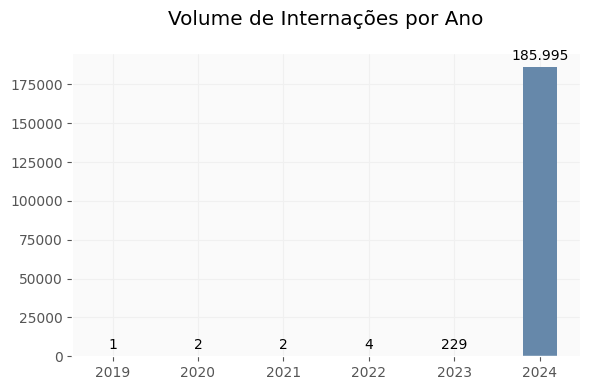

In [92]:
internacoes.sort_values(by='DT_INTERNA', ascending=True).head()

# Agrupando por ano e contando o número de internações
internacoes_por_ano = internacoes.groupby(internacoes['DT_INTERNA'].dt.year).size()

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(6, 4))

anos = internacoes_por_ano.index
volume_internacoes_por_ano = internacoes_por_ano.values

# Criando o gráfico de barras
bars = ax.bar(anos, volume_internacoes_por_ano, width=0.4, color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_internacoes_por_ano], padding=3)

# Adicionando título e rótulos
plt.title('Volume de Internações por Ano', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Como foi verificado acima que os anos anteriores a 2024 possuem um percentual bem menor de informações, estes serão desconsiderados ao longo da análise.

In [93]:
# Criando novo dataframe somente com internações de 2024
internacoes_2024 = internacoes[internacoes['DT_INTERNA'].dt.year == 2024]

#### Série temporal: evolução do volume de internações ao longo do ano de 2024

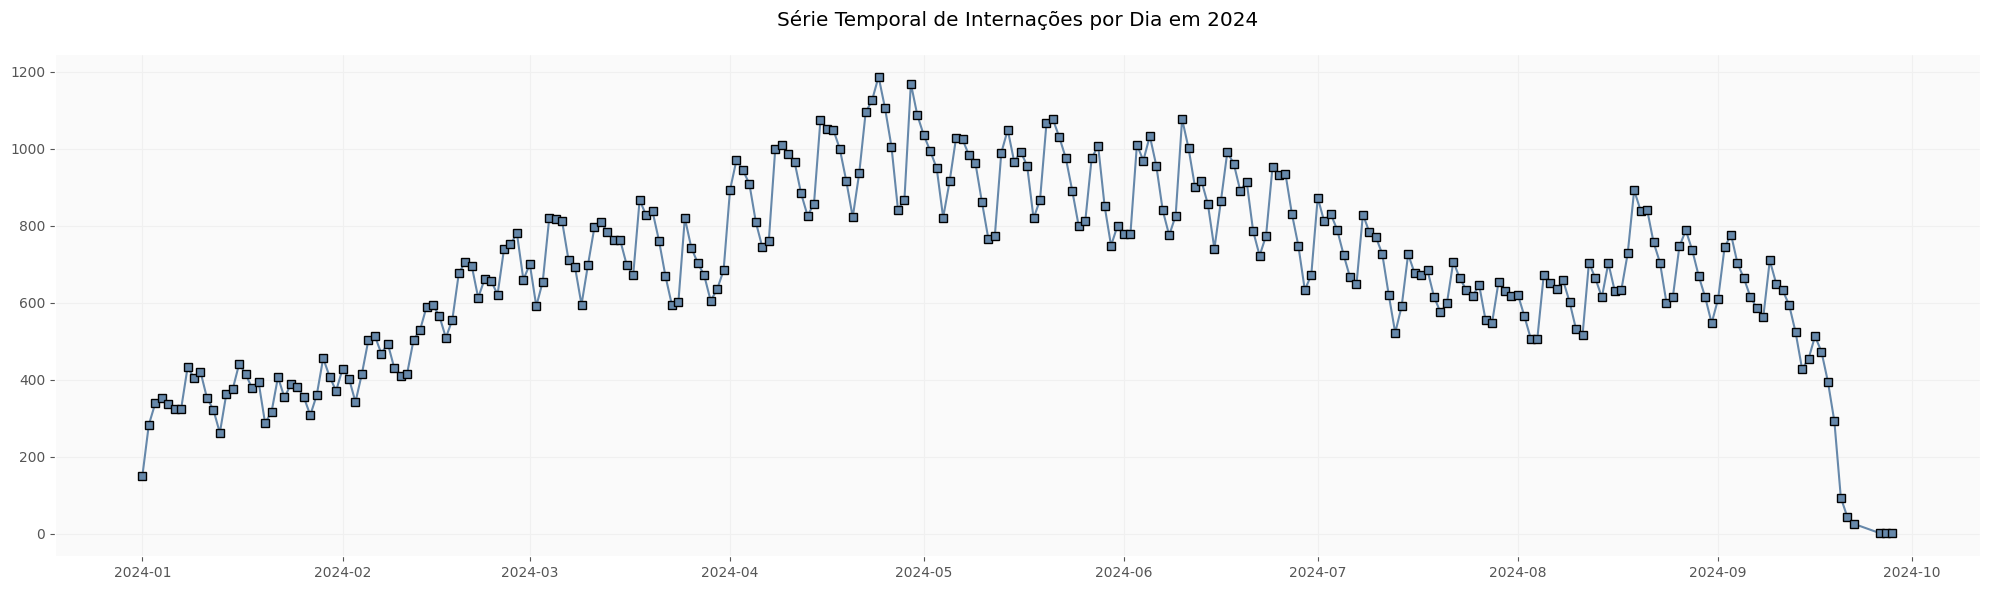

In [94]:
# Agrupando por dia e contando o número de internações
internacoes_por_dia = internacoes_2024.groupby(internacoes_2024['DT_INTERNA'].dt.date).size()

dias = internacoes_por_dia.index
volume_internacoes_por_dia = internacoes_por_dia.values

# Plotando o gráfico de linha
plt.figure(figsize=(20,6))
plt.plot(dias, volume_internacoes_por_dia, marker='s',
         markerfacecolor=corDefault, markeredgecolor='black',
         color = corDefault)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Adicionando título e rótulos
plt.title('Série Temporal de Internações por Dia em 2024', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Dando continuidade a análise, faremos a agregação dos dados por mês. De acordo com o que vimos anteriormente, o mês de Abril concentrava a maior quantidade de internações do ano de 2024. <br/>
Vamos conferir?

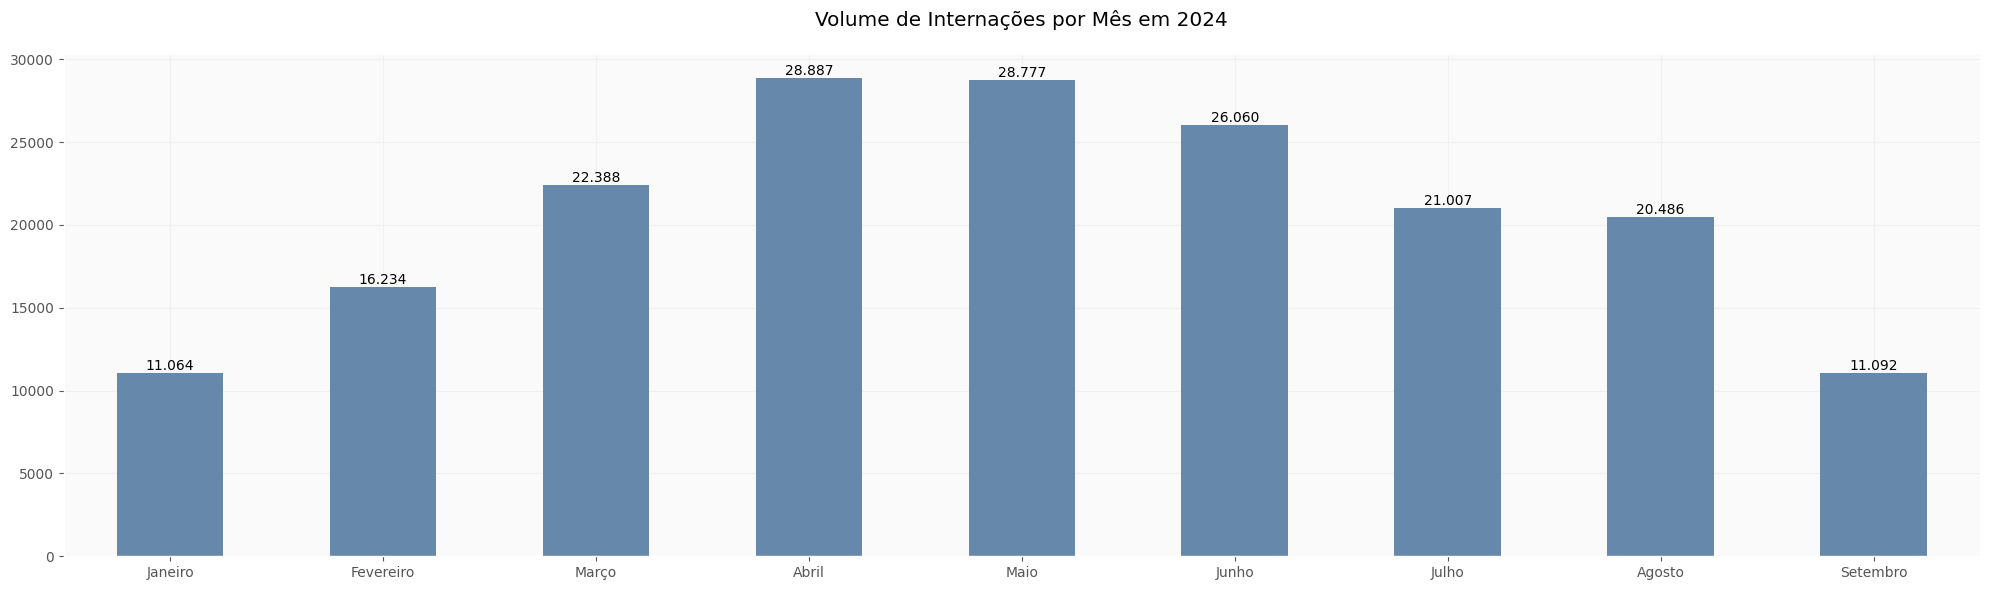

In [95]:
# Convertendo o número do mês para o respectivo nome
internacoes_2024['MES_INTERNACAO'] = internacoes_2024['DT_INTERNA'].dt.month.map(meses)
internacoes_2024['NUMERO_MES_INTERNACAO'] = internacoes_2024['DT_INTERNA'].dt.month

# Agrupando por mês e contando o número de internações
internacoes_por_mes = internacoes_2024.groupby(['NUMERO_MES_INTERNACAO','MES_INTERNACAO']).size()

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Criando o gráfico de barras empilhadas
internacoes_por_mes.plot(kind='bar', stacked=False, ax=ax,  color = corDefault)

#Acrescenta os valores sobre as barras
ax.bar_label(ax.containers[0],
             labels=[f'{i:,}'.replace(',', '.') for i in internacoes_por_mes.values])

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Adicionando título e rótulos
plt.title('Volume de Internações por Mês em 2024', pad=20)

# Personalizando o gráfico
ax.set_xticklabels(internacoes_por_mes.reset_index()['MES_INTERNACAO'], rotation=0)
ax.set_xlabel('') # Removendo a label do eixo X

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Perfeito! Este visual confirmou que de fato o mês de Abril foi o que recebeu maior quantitativo de internações. <br/>

Agora vamos analisar quantas destas internações necessitaram de uma UTI.

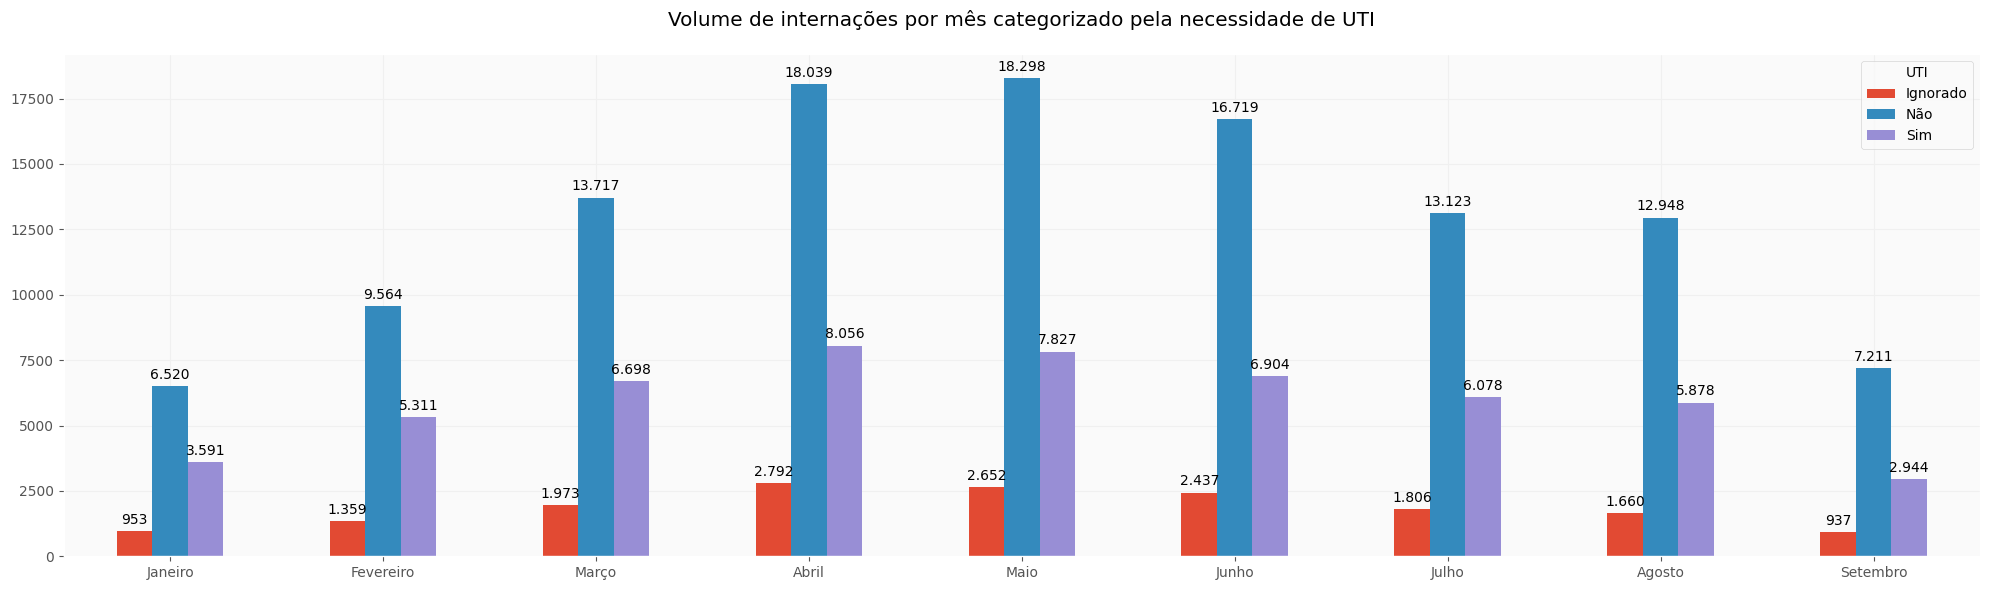

In [96]:
# Preenchendo valores nulos com 'Ignorado'
internacoes_2024['UTI'] = internacoes_2024['UTI'].fillna('Ignorado')

# Agrupando por necessidade de UTI por mês
grupo_uti_mes = internacoes_2024.groupby(['NUMERO_MES_INTERNACAO','MES_INTERNACAO', 'UTI']).size().unstack(fill_value=0)

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Criando o gráfico de barras empilhadas
grupo_uti_mes.plot(kind='bar', stacked=False, ax=ax)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container], padding=3)

# Personalizando o gráfico
ax.set_title('Volume de internações por mês categorizado pela necessidade de UTI', pad=20)
ax.set_xticklabels(grupo_uti_mes.reset_index()['MES_INTERNACAO'], rotation=0)
ax.legend(title='UTI', loc='upper right', fontsize=10)
ax.set_xlabel('') # Removendo a label do eixo X

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Pelo que podemos identificar, a maior parte das internações por mês não necessitou de UTI.

#### Volume de internações por Unidade Federativa

Conforme já abordado anteriormente, o estado de São Paulo é aquele que possui maior número de internações registradas.<br/>
O gráfico também permite identificar a grande diferença entre o volume de internações do estado de São Paulo e as demais Unidades Federativas.<br/>
São Paulo é seguido do estado do Paraná e há uma queda de aproximadamente 60% no número de internações entre estes dois estados.

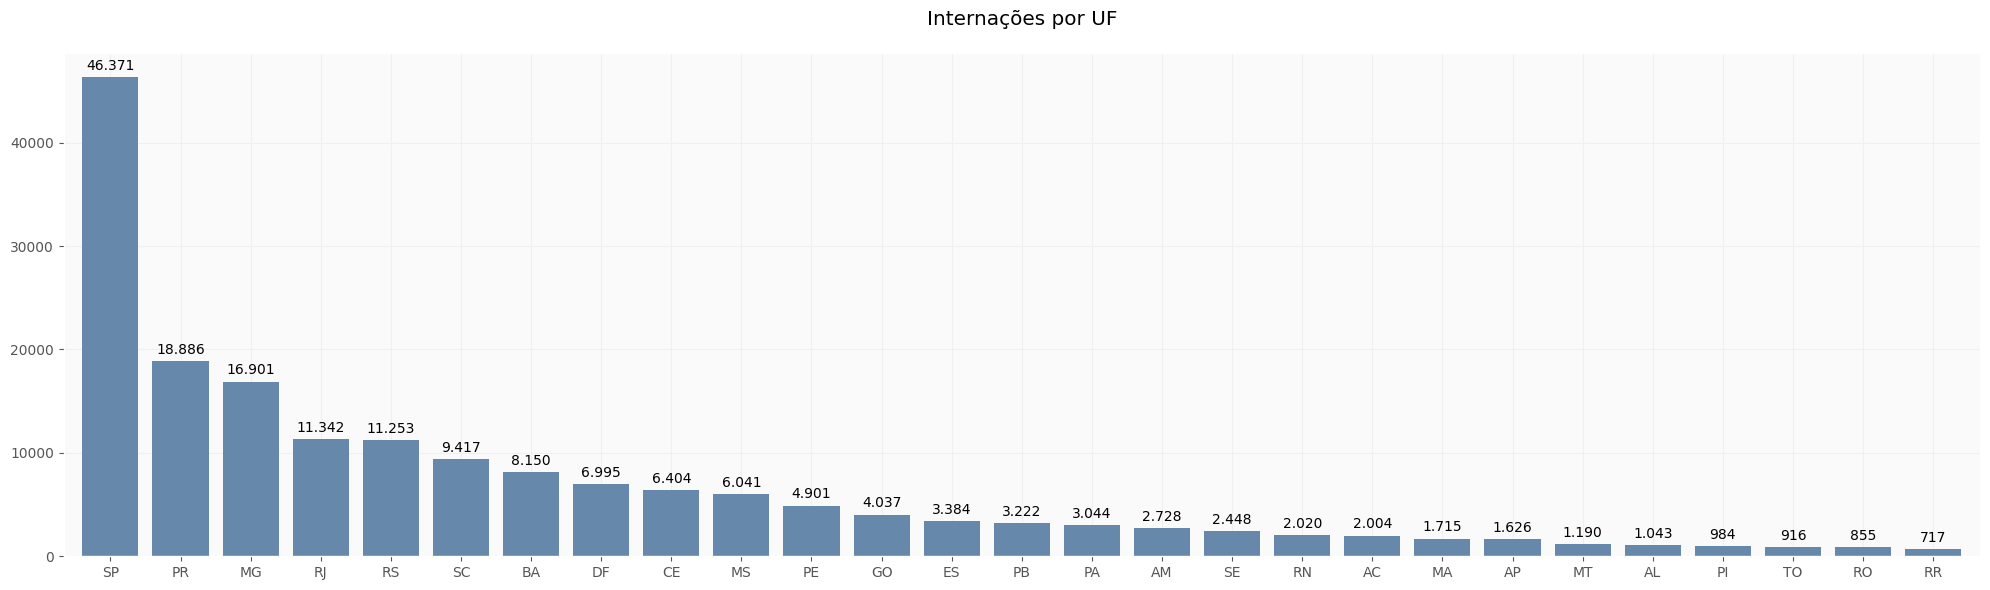

In [97]:
# Agrupando por UF e contando o número de internações
internacoes_por_uf = internacoes_2024.groupby(internacoes_2024['SG_UF_INTE']).size()

# Ordenando pelas maiores quantidades
internacoes_por_uf = internacoes_por_uf.sort_values(ascending=False)

ufs = internacoes_por_uf.index
volume_internacoes_por_uf = internacoes_por_uf.values

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize=(20, 6))

# Cria o gráfico de barras
ax.bar(ufs, volume_internacoes_por_uf, color = corDefault)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container], padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Adicionando título e rótulos
plt.title('Internações por UF', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Aprentemente a região Sudeste possui maior volume de internações, enquanto a região Norte possui a menor quantidade.<br/>
Vamos detalhar mais um pouco nossa análise para verificar a distribuição das internações nas regiões geográficas.

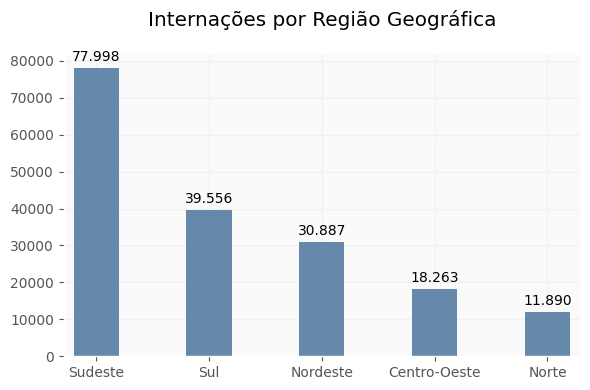

In [98]:
# Convertendo o número do mês para o respectivo nome
internacoes_2024['REGIAO_GEOGRAFICA'] = internacoes_2024['SG_UF_INTE'].map(regioes_estados)

# Agrupando por região e contando o número de internações
internacoes_por_regiao_uf = internacoes_2024.groupby(internacoes_2024['REGIAO_GEOGRAFICA']).size()

# Ordenando pelas maiores quantidades
internacoes_por_regiao_uf = internacoes_por_regiao_uf.sort_values(ascending=False)

regioes = internacoes_por_regiao_uf.index
volume_internacoes_por_regiao_uf = internacoes_por_regiao_uf.values

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize=(6, 4))

# Cria o gráfico de barras
ax.bar(regioes, volume_internacoes_por_regiao_uf,  width=0.4, color = corDefault)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container], padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.02)

# Adicionando título e rótulos
plt.title('Internações por Região Geográfica', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Conforme suspeitado, as regiões Sudeste e Sul apresentam os maiores volumes de internação. <br/>
Um fator que pode influenciar este cenário é: sabendo que o número de internações é maior nos meses de inverno, as regiões do Sudeste e do Sul (principalmente) são aquelas mais impactadas pela queda de temperatura.

#### BoxPlots

**Idade**

Pelo boxplot abaixo, confirmamos as informações vistas anteriormente:
* 50% dos Pacientes possui idade entre 0 e 60 anos
* dispersão significativa das idades, porém uma mediana baixa (6 anos, como visto acima) indicando que a maior parte dos Pacientes é bem jovem
* idades acima de 100 anos não foram identificadas como *outliers*

<br/>**Período de Internações** <br/>
Pelo boxplot abaixo, vemos que:
* 50% das internações ocorrem entre os meses de Março e Julho
* não existem *outliers*
* mediana e média são bem próximas e apontam para o mês de Maio

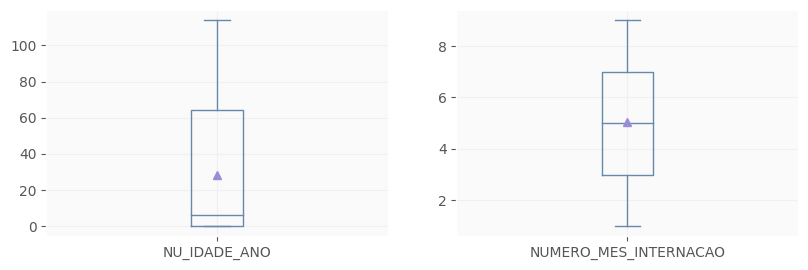

In [99]:
# Boxplot
internacoes_2024.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10), showmeans=True, color = corDefault)
plt.show()

#### Análise de perfil dos Pacientes

**Idade**

Veremos agora com mais detalhes como estão distribuídas as idades dos Pacientes, iniciando com um gráfico de **Faixa Etária**.


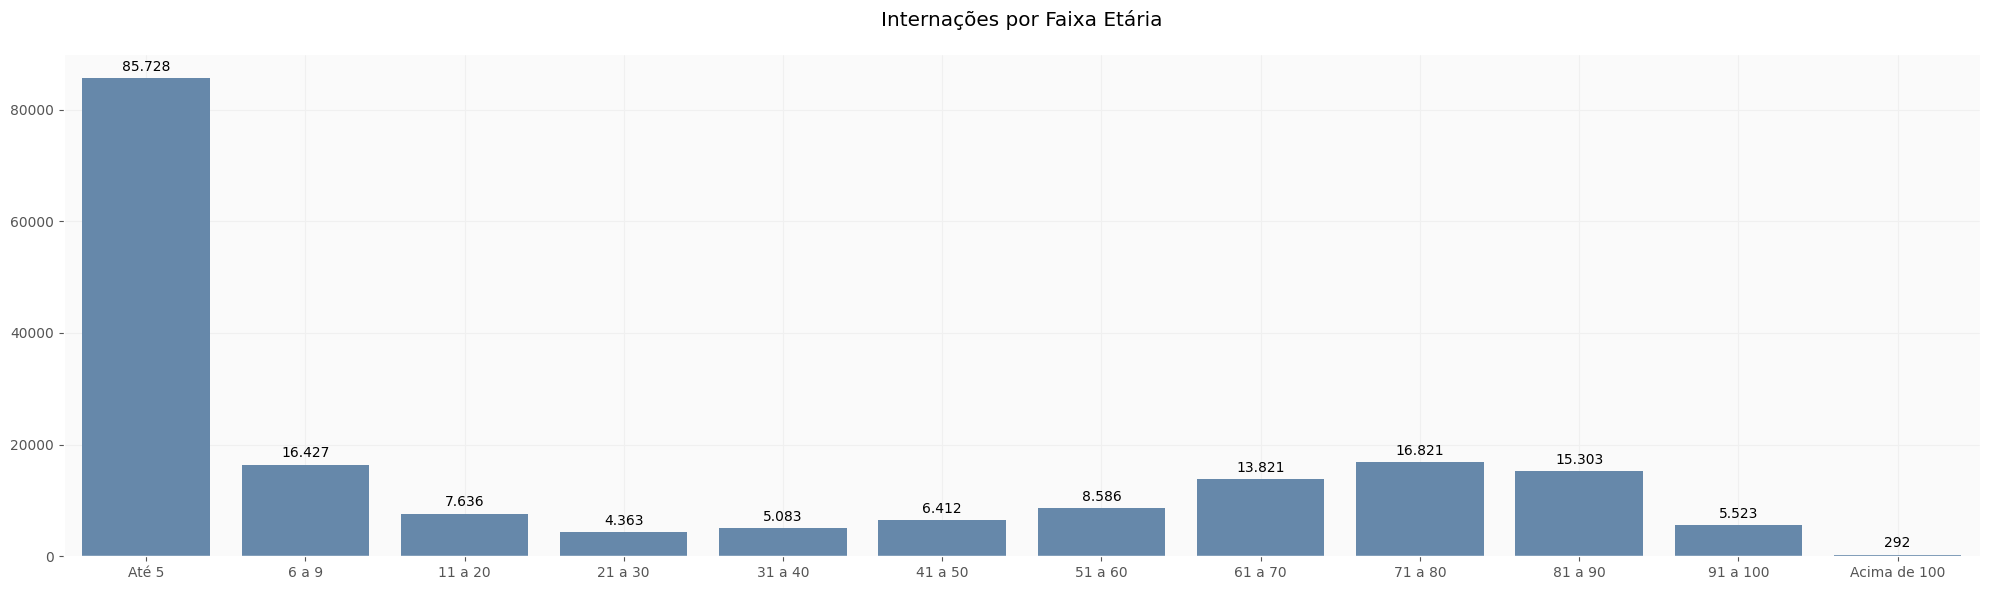

In [100]:
# Definindo as faixas etárias
bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')] # Definindo um valor superior ilimitado para cobrir as idades acima de 100
labels = ['Até 5', '6 a 9', '11 a 20', '21 a 30', '31 a 40', '41 a 50', '51 a 60', '61 a 70', '71 a 80', '81 a 90', '91 a 100', 'Acima de 100']

# Criando uma nova coluna com as faixas etárias
internacoes_2024['FAIXA_ETARIA'] = pd.cut(internacoes_2024['NU_IDADE_ANO'], bins=bins, labels=labels, right=False)

# Contando a quantidade de pessoas em cada faixa etária
faixa_etaria_count = internacoes_2024['FAIXA_ETARIA'].value_counts().sort_index()

faixa_etaria = faixa_etaria_count.index
volume_faixa_etaria = faixa_etaria_count.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Criando o gráfico de barras
bars = ax.bar(faixa_etaria, volume_faixa_etaria, color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_faixa_etaria], padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Criando o gráfico de barras
plt.bar(faixa_etaria_count.index, faixa_etaria_count.values, color = corDefault)
plt.title('Internações por Faixa Etária', pad=20)
plt.tight_layout()
plt.show()

A seguir, focaremos no quantitativo de Pacientes internados com **até 60 anos de idade**.

Veremos que a grande maioria dos Pacientes se tratam de bebês que ainda não completaram seu primeiro ano de vida.

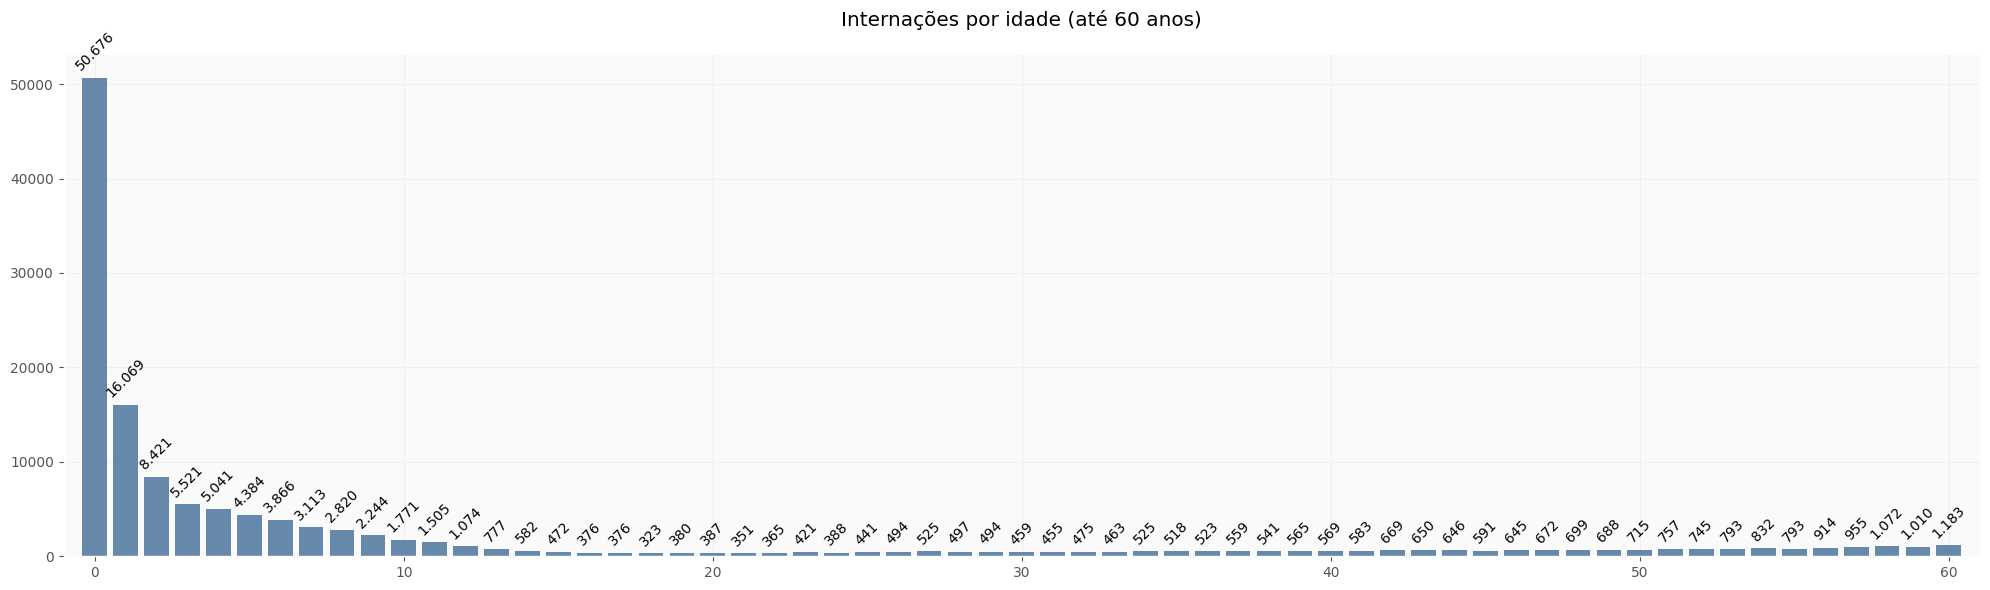

In [101]:
# Agrupando por idade e contando o número de internações
internacoes_por_idade = internacoes_2024.groupby(internacoes_2024['NU_IDADE_ANO']).size()

# Garantindo que registros com datas futuras de 2024 serão desconsiderados na análise
internacoes_idade_ate_60 = internacoes_por_idade[internacoes_por_idade.index <= 60]

idades_ate_60 = internacoes_idade_ate_60.index
volume_internacoes_ate_60 = internacoes_idade_ate_60.values

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize=(20, 6))

# Cria o gráfico de barras
ax.bar(idades_ate_60, volume_internacoes_ate_60, color = corDefault)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container],
                 rotation=45,
                 padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Adicionando título e rótulos
plt.title('Internações por idade (até 60 anos)', pad=20)

# Exibindo o gráfico
plt.xticks()
plt.tight_layout()
plt.show()

Agora, veremos o quantitativo de Pacientes com mais de 60 anos de idade.

O pico é alcançado com 76 anos de idade.

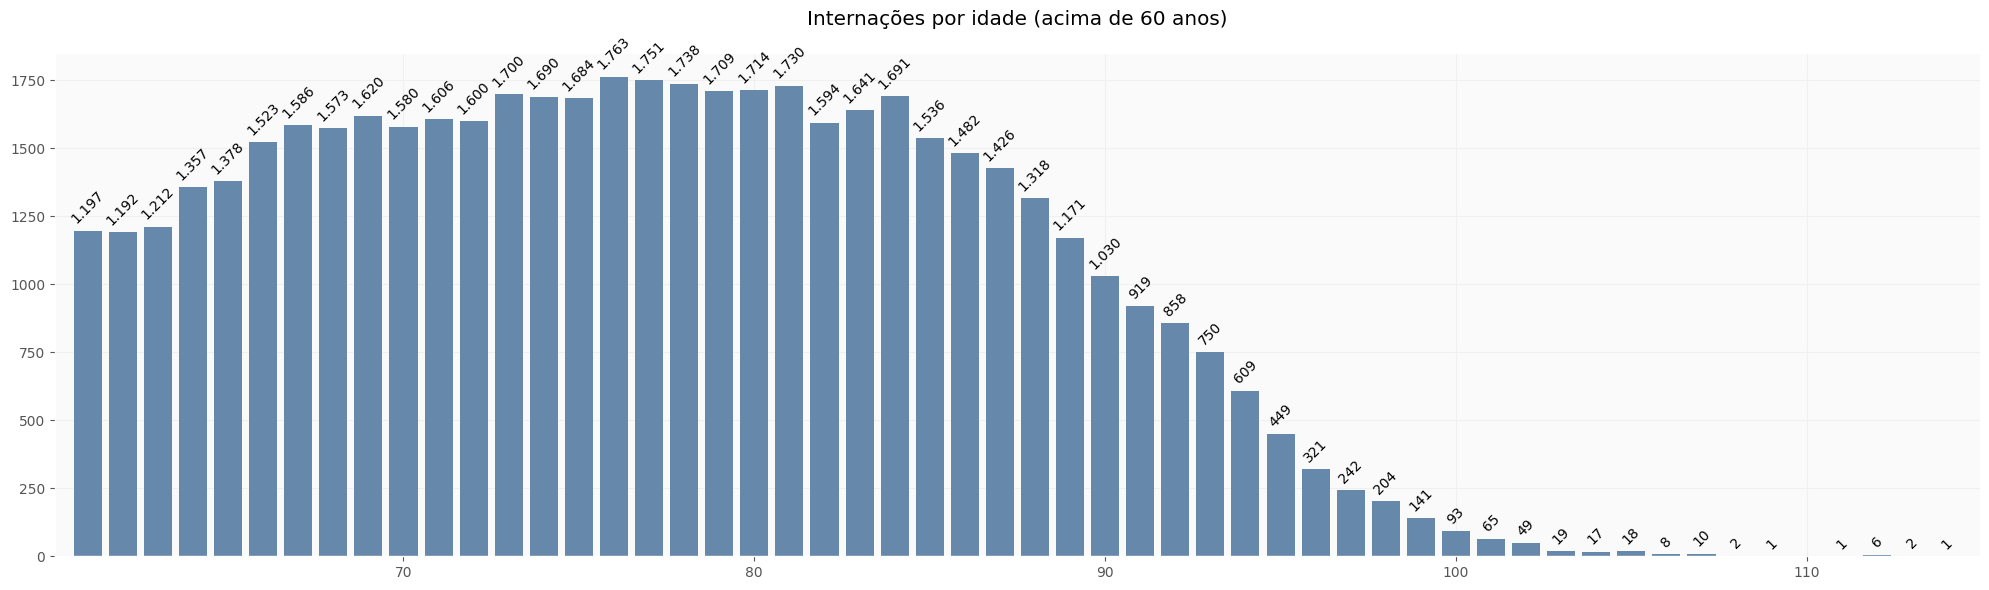

In [102]:
# Agrupando por idade e contando o número de internações
internacoes_por_idade = internacoes_2024.groupby(internacoes_2024['NU_IDADE_ANO']).size()

# Garantindo que registros com datas futuras de 2024 serão desconsiderados na análise
internacoes_idade_acima_60 = internacoes_por_idade[internacoes_por_idade.index > 60]

idades_acima_60 = internacoes_idade_acima_60.index
volume_internacoes_acima_60 = internacoes_idade_acima_60.values

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize=(20, 6))

# Cria o gráfico de barras
ax.bar(idades_acima_60, volume_internacoes_acima_60, color = corDefault)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container],
                 rotation=45,
                 padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Adicionando título e rótulos
plt.title('Internações por idade (acima de 60 anos)', pad=20)

# Exibindo o gráfico
plt.xticks()
plt.tight_layout()
plt.show()

**Sexo**

Pela visualização abaixo, confirmamos as informações vistas anteriormente:
* a maior parte dos Pacientes é do sexo Masculino
* porém, em termos percentuais, a quantidade de homens e mulheres encontra-se equilibrada

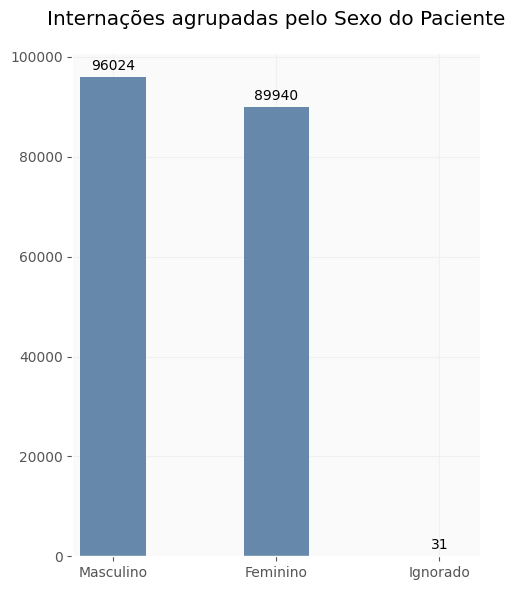

In [103]:
# Para haver mais clareza no gráfico, serão renomeados os valores de 'M', 'F' e 'I'
# para 'Masculino', 'Feminino' e 'Ignorado'
internacoes_2024['CS_SEXO'] = internacoes_2024['CS_SEXO'].replace({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})

# Agrupando por sexo e contando o número de internações
internacoes_por_sexo = internacoes_2024.groupby(internacoes_2024['CS_SEXO']).size()

# Ordenando pelas maiores quantidades
internacoes_por_sexo = internacoes_por_sexo.sort_values(ascending=False)

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize=(5, 6))

# Criando o gráfico
plt.bar(internacoes_por_sexo.index, internacoes_por_sexo.values, width=0.4,
        color = corDefault)

#Acrescenta os valores sobre as barras
ax.bar_label(ax.containers[0], padding=3)

# Ajustando as margens no eixo X
ax.margins(x=0.02)

# Adicionando título e rótulos
plt.title('Internações agrupadas pelo Sexo do Paciente', pad=20)

# Exibindo o gráfico
plt.xticks()
plt.tight_layout()
plt.show()

**Idade e Sexo**

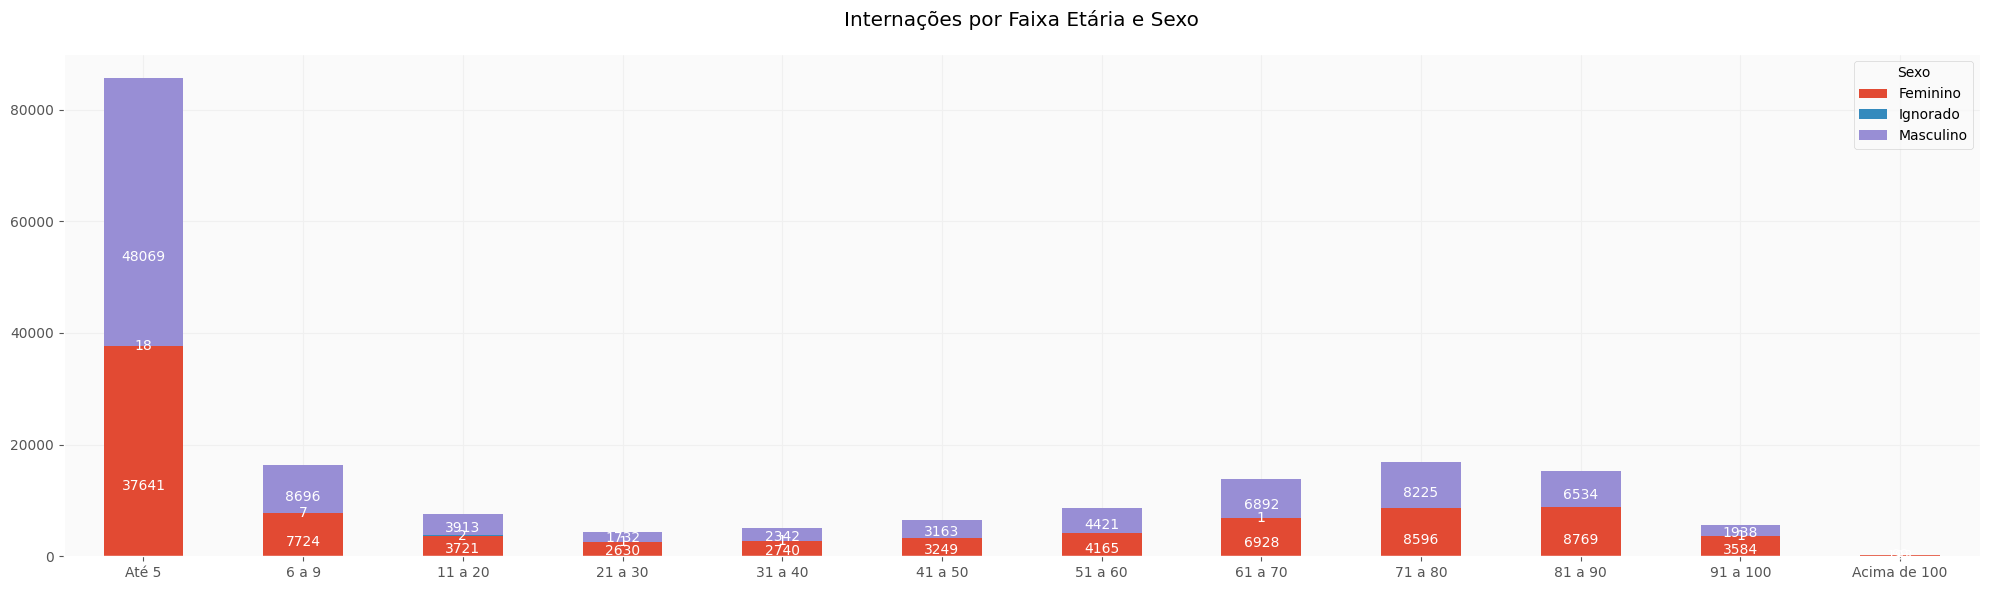

In [104]:
# Agrupando por faixa etária e sexo
grupo_faixa_etaria_sexo = internacoes_2024.groupby(['FAIXA_ETARIA', 'CS_SEXO']).size().unstack(fill_value=0)

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(20, 6))

# Criando o gráfico de barras empilhadas
grupo_faixa_etaria_sexo.plot(kind='bar', stacked=True, ax=ax)

# # Adicionando rótulos em cada segmento das barras
for i in range(len(grupo_faixa_etaria_sexo)):  # Para cada faixa etária (grupo)
    cumulativo = 0  # Para rastrear a altura acumulada das barras empilhadas
    for j, coluna in enumerate(grupo_faixa_etaria_sexo.columns):  # Para cada categoria (Masculino, Feminino, Ignorado)
        valor = grupo_faixa_etaria_sexo.iloc[i][coluna]  # Valor da barra empilhada
        if valor > 0:  # Evitar rótulos em barras com valor zero
            ax.text(i, cumulativo + valor / 3, str(valor), ha='center', va='center', color='white')
        cumulativo += valor  # Atualiza a altura acumulada para a próxima categoria


# Ajustando as margens no eixo X
ax.margins(x=0.01)

# Personalizando o gráfico
ax.set_title('Internações por Faixa Etária e Sexo', pad=20)
ax.set_xticklabels(grupo_faixa_etaria_sexo.index, rotation=0)
ax.legend(title='Sexo', loc='upper right', fontsize=10)
ax.set_xlabel('') # Removendo a label do eixo X

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### Análise de resultados de exames

**Testes Antigênicos**

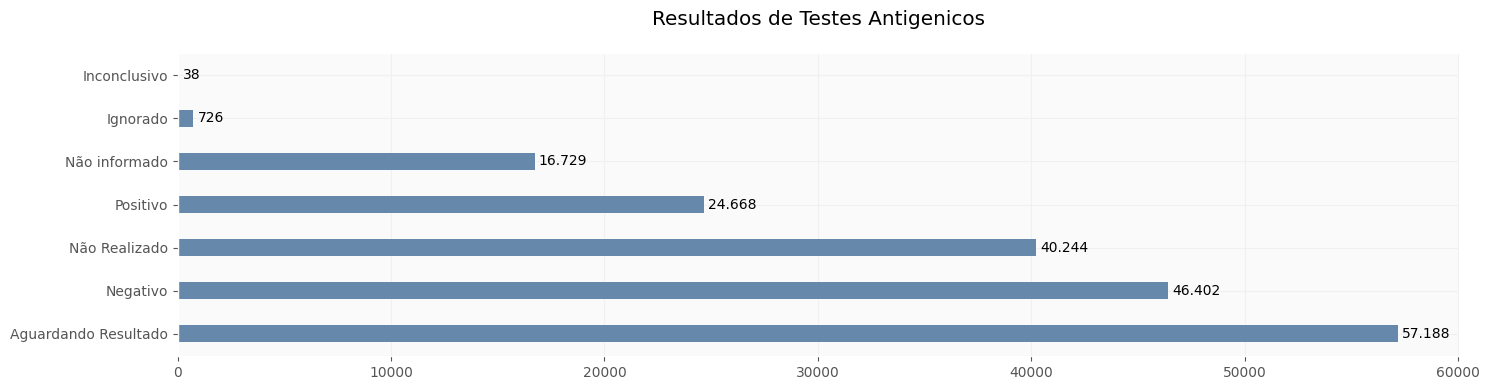

In [105]:
# Tratamento de dados nulos para melhor análise dos dados
internacoes_2024['RES_AN'] = internacoes_2024['RES_AN'].fillna('Não informado')

# Agrupando os diferentes tipos de resultados do Teste Antigênico
resultados_antigenico = internacoes_2024.groupby(internacoes_2024['RES_AN']).size()

# Ordenando pelas maiores quantidades
resultados_antigenico = resultados_antigenico.sort_values(ascending=False)

descricao_resultados_antigenico = resultados_antigenico.index
volume_resultados_antigenico = resultados_antigenico.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(15, 4))

# Criando o gráfico de barras
bars = ax.barh(descricao_resultados_antigenico, volume_resultados_antigenico,
               height=0.4, color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_resultados_antigenico], padding=3)

# Adicionando título e rótulos
plt.title('Resultados de Testes Antigenicos', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### Análise de vacinação



**Vacinação de COVID**

Pela visualização abaixo, vemos que a maior parte dos Pacientes internados não tomou a vacina de COVID.
Porém, é importante notar, que percentualmente, os dados de quem tomou a vacina são equivalentes:
* Não tomaram: ~50%
* Tomaram: ~47%

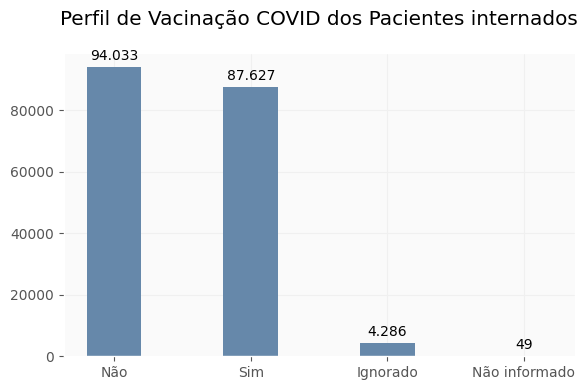

In [106]:
# Tratamento de dados nulos para melhor análise dos dados
internacoes_2024['VACINA_COV'] = internacoes_2024['VACINA_COV'].fillna('Não informado')

# Agrupando os registros para identificar os quantitativos de quem tomou ou não a vacina de COVID
grupo_vacina_covid = internacoes_2024.groupby(internacoes_2024['VACINA_COV']).size()

# Ordenando pelas maiores quantidades
grupo_vacina_covid = grupo_vacina_covid.sort_values(ascending=False)

indicador_vacina_covid = grupo_vacina_covid.index
volume_vacina_covid = grupo_vacina_covid.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(6, 4))

# Criando o gráfico de barras
bars = ax.bar(indicador_vacina_covid, volume_vacina_covid, width=0.4,
              color = corDefault)

#Acrescenta os valores sobre as barras formatando separador de milhar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label.get_height()):,}'.replace(',', '.') for label in container], padding=3)

# Adicionando título e rótulos
plt.title('Perfil de Vacinação COVID dos Pacientes internados', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

**Relação entre os Pacientes diagnosticados com COVID e vacinação**

Considerando agora somente os Pacientes internados que foram de fato diagnosticados com COVID, vemos que a maioria destes Pacientes foram vacinados contra a doença. <br/>
Acaba sendo um fato bem curioso, visto que nossa intuição diria que a maior parte dos Pacientes diagnosticados com COVID teriam tomado a vacina.

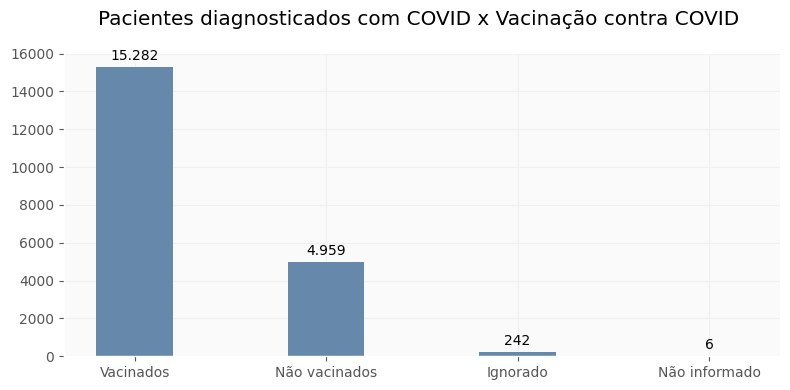

In [107]:
# Filtrando pelos casos de internação cujos Pacientes tiveram diagnóstico confirmado de COVID
internacoes_covid = internacoes_2024[internacoes_2024['CLASSI_FIN'] == 'SRAG por covid-19']

# Substituição de valores para maior clareza dos dados
internacoes_covid['VACINA_COV']= internacoes_covid['VACINA_COV'].map({'Sim': 'Vacinados', 'Não': 'Não vacinados', 'Ignorado': 'Ignorado', 'Não informado': 'Não informado'})

# Agrupando estes registros para identificar os quantitativos de quem tomou ou não a vacina de COVID
grupo_diagn_covid_vacina = internacoes_covid.groupby(internacoes_covid['VACINA_COV']).size()

# Ordenando pelas maiores quantidades
grupo_diagn_covid_vacina = grupo_diagn_covid_vacina.sort_values(ascending=False)

categoria_vacinacao_covid = grupo_diagn_covid_vacina.index
volume_categoria_vacinacao_covid = grupo_diagn_covid_vacina.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(8, 4))

# Criando o gráfico de barras
bars = ax.bar(categoria_vacinacao_covid, volume_categoria_vacinacao_covid,
              width=0.4,
              color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_categoria_vacinacao_covid], padding=3)

# Adicionando título e rótulos
plt.title('Pacientes diagnosticados com COVID x Vacinação contra COVID ', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### Análise de classificação dos Diagnósticos

Com base no resultado curioso da análise acima, vamos analisar quais foram os Diagnósticos finais dos Pacientes internados e seus respectivos quantitativos. <br/>
Ao final da análise, veremos que dentre as 5 possibilidades de diagnóstico possíveis, a síndrome por Covid acabou ocupando o terceiro lugar, correspondendo a aproximadamente 10% dos casos. <br/>
O que nos aponta a outra informação curiosa: a maior parte dos casos (~44%) corresponde a uma síndrome não especificada.

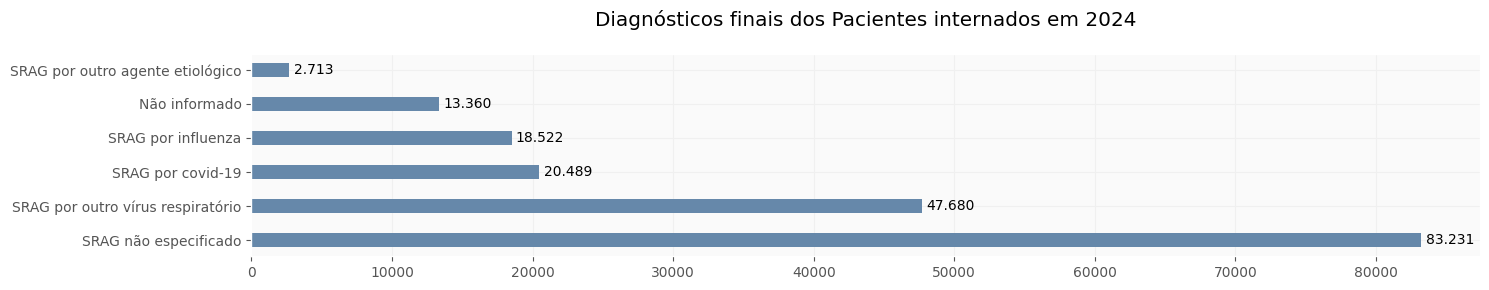

In [108]:
# Tratamento de dados nulos para melhor análise dos dados
internacoes_2024['CLASSI_FIN'] = internacoes_2024['CLASSI_FIN'].fillna('Não informado')

# Agrupando estes registros pelo Diagnóstico final
grupo_diagn_final = internacoes_2024.groupby(internacoes_2024['CLASSI_FIN']).size()

# Ordenando pelas maiores quantidades
grupo_diagn_final = grupo_diagn_final.sort_values(ascending=False)

diagnostico_final = grupo_diagn_final.index
volume_diagnostico_final = grupo_diagn_final.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(15, 3))

# Criando o gráfico de barras
bars = ax.barh(diagnostico_final, volume_diagnostico_final, height=0.4,
              color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_diagnostico_final], padding=3)

# Adicionando título e rótulos
plt.title('Diagnósticos finais dos Pacientes internados em 2024', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### Evolução dos casos

O gráfico a seguir apresenta que a grande maioria das internações resultaram na cura dos Pacientes.

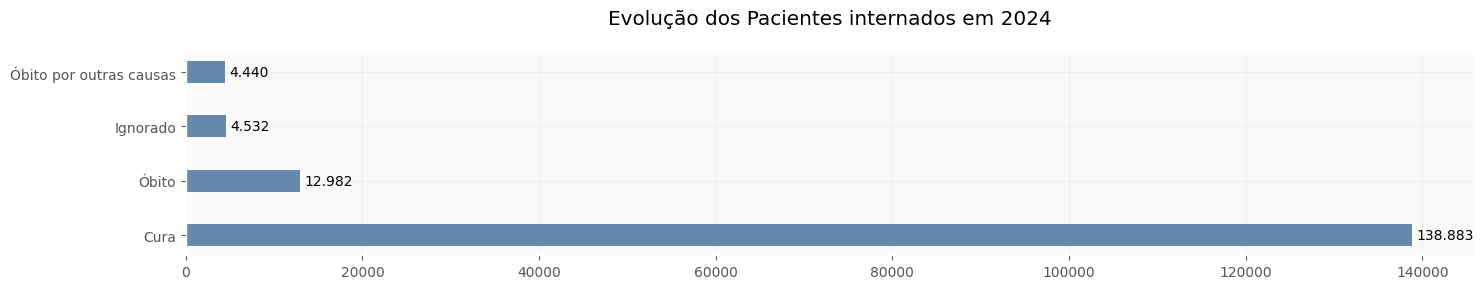

In [109]:
# Tratamento de dados nulos para melhor análise dos dados
#internacoes_2024['CLASSI_FIN'] = internacoes_2024['CLASSI_FIN'].fillna('Não informado')

# Agrupando estes registros pela evolução
grupo_evolucoes = internacoes_2024.groupby(internacoes_2024['EVOLUCAO']).size()

# Ordenando pelas maiores quantidades
grupo_evolucoes = grupo_evolucoes.sort_values(ascending=False)

evolucoes = grupo_evolucoes.index
volume_evolucoes = grupo_evolucoes.values

# Ajustando o tamanho do gráfico
fig, ax = plt.subplots(figsize=(15, 3))

# Criando o gráfico de barras
bars = ax.barh(evolucoes, volume_evolucoes, height=0.4,
              color = corDefault)

# Inserindo os valores acima das barras
ax.bar_label(bars, labels=[f'{i:,}'.replace(',', '.') for i in volume_evolucoes], padding=3)

# Adicionando título e rótulos
plt.title('Evolução dos Pacientes internados em 2024', pad=20)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

## Pré Processamento de Dados
Nesta seção abordaremos mais a fundo o Pré Processamento de Dados considerando que os dados a serem trabalhados servirão de input para um modelo de Machine Learning de Classificação.<br/>
O objetivo é, que a partir das features de entrada, o modelo seja capaz de classificar o Diagnóstico final de um determinado Paciente (indicado pela variável 'CLASSI_FIN').

### Feature Selection
Com base na análise realizada até aqui, entendemos que nem todas as características são relevantes para a classificação do Diagnóstico. <br/>
Basicamente serão selecionados atributos relacionados a:
* sintomas do Paciente
* idade, gênero e raça do Paciente
* indicativo se tomou (ou não) a vacina contra Covid
* indicativo se foi internado e/ou encaminhado para a UTI
* indicativo se possui algum fator de risco
* resultado de exames (PCR e Antigeno)
* evolução do caso (indicando se houve ou não a Cura)

In [110]:
# Criando uma cópia do dataframe selecionando apenas os atributos que entende-se relevantes para o problema de Classificação
df_srga_filtrado = internacoes_2024[['CS_SEXO', 'CS_RACA', 'NU_IDADE_ANO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'FATOR_RISC', 'PCR_RESUL',
                            'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'RES_AN', 'VACINA_COV', 'HOSPITAL', 'UTI', 'EVOLUCAO', 'CLASSI_FIN']]
df_srga_filtrado.head()

,CS_SEXO,CS_RACA,NU_IDADE_ANO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,PCR_RESUL,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV,HOSPITAL,UTI,EVOLUCAO,CLASSI_FIN
0,Feminino,Parda,26,Sim,Sim,Não,Sim,Sim,Sim,Não,Não,Não,NaN,Não,Não,Não,Não,Negativo,Sim,Sim,Não,Ignorado,SRAG não especificado
2,Feminino,Parda,0,Não,Sim,Não,Sim,Sim,Não,Sim,Não,Não,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Não,Sim,Não,Cura,SRAG não especificado
3,Masculino,Branca,0,Sim,Sim,Não,Sim,Sim,Sim,Sim,Não,Não,Detectável,Não,Não,Não,Não,Positivo,Não,Sim,Sim,Óbito,SRAG por covid-19
4,Feminino,Branca,34,Sim,Sim,Sim,Não,Sim,Não,Não,Não,Não,NaN,Não,Sim,Não,Não,Positivo,Sim,Sim,Não,Cura,SRAG por covid-19
5,Masculino,Branca,74,Sim,Sim,Não,Sim,Sim,Não,Não,Não,Sim,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Sim,Sim,Não,Cura,SRAG não especificado


### Tratamento de Missings

In [111]:
# Verificando nulos no dataset
df_srga_filtrado.isnull().sum()

,0
CS_SEXO,0
CS_RACA,0
NU_IDADE_ANO,0
FEBRE,19382
TOSSE,11824
GARGANTA,46137
DISPNEIA,20377
DESC_RESP,22394
SATURACAO,28111
DIARREIA,45365


<Axes: >

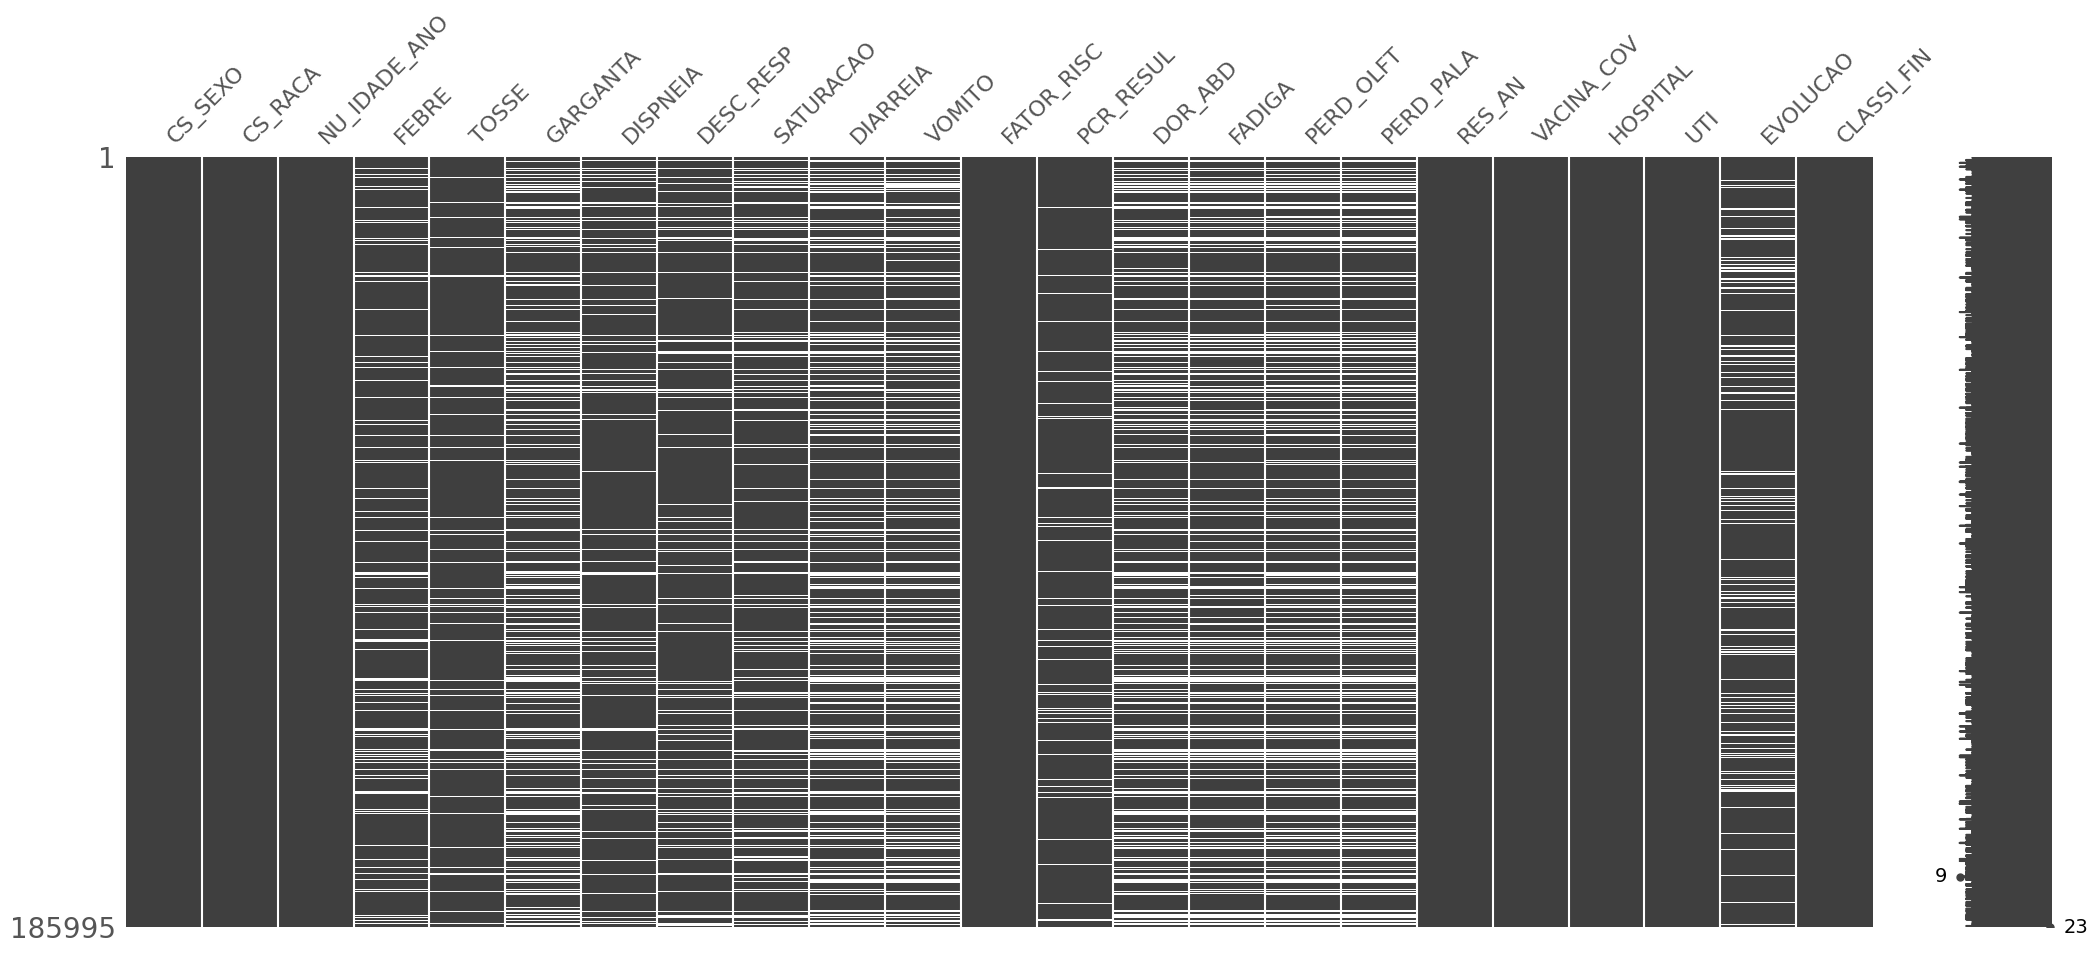

In [112]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_srga_filtrado)

Como observado acima, todas as colunas que possuem algum dado nulo se tratam de dados categóricos.<br/>
Será utilizada a seguinte estratégia para o tratamento de dados nulos:

* todos os registros nulos das variáveis categóricas serão substituídos pela expressão 'Não Informado'

<Axes: >

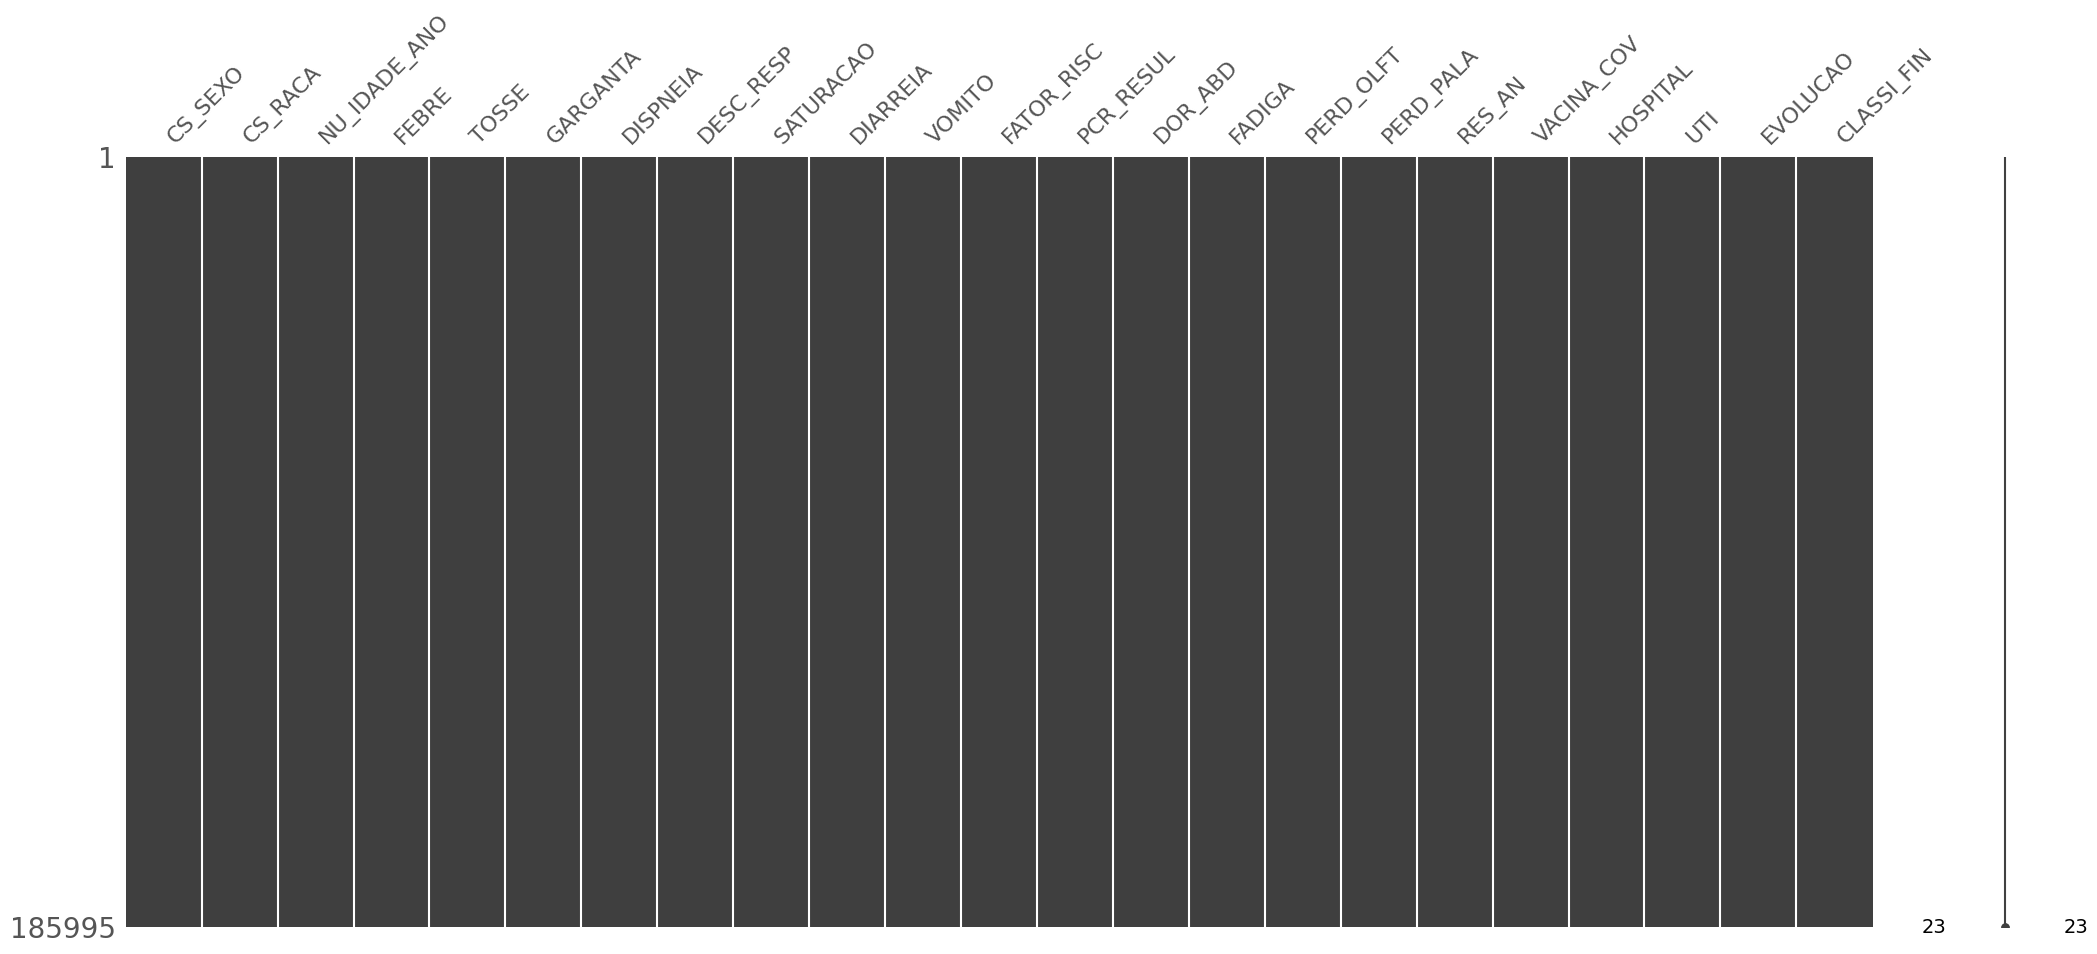

In [113]:
# Substituindo os valores nulos das variáveis categóricas por 'Não informado'
df_srga_filtrado.fillna('Não informado', inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_srga_filtrado)

In [114]:
# Exibindo as primeiras linhas do dataset após o tratamento de dados nulos
df_srga_filtrado.head()

,CS_SEXO,CS_RACA,NU_IDADE_ANO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,PCR_RESUL,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV,HOSPITAL,UTI,EVOLUCAO,CLASSI_FIN
0,Feminino,Parda,26,Sim,Sim,Não,Sim,Sim,Sim,Não,Não,Não,Não informado,Não,Não,Não,Não,Negativo,Sim,Sim,Não,Ignorado,SRAG não especificado
2,Feminino,Parda,0,Não,Sim,Não,Sim,Sim,Não,Sim,Não,Não,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Não,Sim,Não,Cura,SRAG não especificado
3,Masculino,Branca,0,Sim,Sim,Não,Sim,Sim,Sim,Sim,Não,Não,Detectável,Não,Não,Não,Não,Positivo,Não,Sim,Sim,Óbito,SRAG por covid-19
4,Feminino,Branca,34,Sim,Sim,Sim,Não,Sim,Não,Não,Não,Não,Não informado,Não,Sim,Não,Não,Positivo,Sim,Sim,Não,Cura,SRAG por covid-19
5,Masculino,Branca,74,Sim,Sim,Não,Sim,Sim,Não,Não,Não,Sim,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Sim,Sim,Não,Cura,SRAG não especificado


### Separação entre dados de treino e teste

In [115]:
# Separando os dados entre X (dados de entrada/input) e Y (dados de saída/target/output)

X = df_srga_filtrado.drop('CLASSI_FIN', axis=1)
y = df_srga_filtrado['CLASSI_FIN']

# Dividindo o dataset em 80% treino e 20% teste utilizando 'train_test_split'
# 'train_test_split': divide os dados de forma aleatória em conjuntos de treino
# e teste, permitindo especificar a proporção de dados de cada conjunto.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
X_train

,CS_SEXO,CS_RACA,NU_IDADE_ANO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,FATOR_RISC,PCR_RESUL,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,RES_AN,VACINA_COV,HOSPITAL,UTI,EVOLUCAO
170405,Feminino,Branca,0,Sim,Não,Não,Sim,Sim,Não,Não,Não,Não,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Não,Sim,Sim,Cura
138752,Masculino,Parda,0,Sim,Sim,Não,Não,Sim,Não,Não,Sim,Não,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Não,Sim,Sim,Cura
9440,Masculino,Branca,95,Não,Sim,Não,Sim,Não,Sim,Não,Não,Sim,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Sim,Sim,Não,Óbito por outras causas
142360,Feminino,Branca,73,Sim,Sim,Não informado,Sim,Não informado,Sim,Não informado,Não informado,Sim,Não Realizado,Não informado,Não informado,Não informado,Não informado,Positivo,Sim,Sim,Não,Cura
135704,Feminino,Parda,0,Sim,Sim,Não,Não,Sim,Não,Não,Não,Sim,Não Realizado,Não,Não,Não,Não,Negativo,Não,Sim,Sim,Cura
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128539,Masculino,Branca,77,Sim,Não,Não,Sim,Não,Não,Não,Não,Sim,Não Detectável,Não,Não,Não,Não,Aguardando Resultado,Sim,Sim,Não,Cura
111212,Masculino,Parda,1,Sim,Sim,Não,Não,Sim,Não,Não,Não,Não,Não Realizado,Não,Não,Não,Não,Positivo,Não,Sim,Sim,Cura
141523,Feminino,Branca,88,Sim,Sim,Não informado,Sim,Sim,Sim,Não informado,Não informado,Sim,Não Detectável,Não informado,Sim,Não informado,Não informado,Não Realizado,Sim,Sim,Não,Cura
157499,Feminino,Parda,1,Não informado,Sim,Não informado,Não informado,Sim,Sim,Não informado,Sim,Não,Detectável,Não informado,Sim,Não informado,Não informado,Aguardando Resultado,Não,Sim,Não,Cura


### Normalização de dados
Utilizaremos esta técnica de pré processamento para tratarmos a única variável numérica presente no dataframe: a idade do Paciente.

In [117]:
# Normalizando os dados relativos a idades do conjunto de treino
X_train[['NU_IDADE_ANO']] = MinMaxScaler().fit_transform(X_train[['NU_IDADE_ANO']])

# Exibindo os dados transformados
print("Dados Originais: \n\n", df_srga_filtrado['NU_IDADE_ANO'])
print("\nDados Normalizados: \n\n", X_train['NU_IDADE_ANO'])

Dados Originais: 

 0         26
2          0
3          0
4         34
5         74
          ..
199527     5
199528    11
199529    96
199530     1
199531     2
Name: NU_IDADE_ANO, Length: 185995, dtype: int64

Dados Normalizados: 

 170405    0.000000
138752    0.000000
9440      0.840708
142360    0.646018
135704    0.000000
            ...   
128539    0.681416
111212    0.008850
141523    0.778761
157499    0.008850
130789    0.000000
Name: NU_IDADE_ANO, Length: 148796, dtype: float64


In [118]:
# Normalizando os dados relativos a idades do conjunto de teste
X_test[['NU_IDADE_ANO']] = MinMaxScaler().fit_transform(X_test[['NU_IDADE_ANO']])

# Exibindo os dados transformados
print("Dados Originais: \n\n", df_srga_filtrado['NU_IDADE_ANO'])
print("\nDados Normalizados: \n\n", X_test['NU_IDADE_ANO'])

Dados Originais: 

 0         26
2          0
3          0
4         34
5         74
          ..
199527     5
199528    11
199529    96
199530     1
199531     2
Name: NU_IDADE_ANO, Length: 185995, dtype: int64

Dados Normalizados: 

 596       0.640351
55596     0.087719
198485    0.631579
196659    0.000000
133944    0.000000
            ...   
66809     0.394737
84498     0.008772
136595    0.263158
6163      0.473684
40892     0.403509
Name: NU_IDADE_ANO, Length: 37199, dtype: float64


### Label Encoding
Utilizaremos esta técnica de pré processamento para tratarmos as variáveis categóricas do dataset.

In [119]:
# Normalizando os dados categóricos do conjunto de de treino
X_train['CS_SEXO'] = LabelEncoder().fit_transform(X_train['CS_SEXO'])
X_train['CS_RACA'] = LabelEncoder().fit_transform(X_train['CS_RACA'])
X_train['NU_IDADE_ANO'] = LabelEncoder().fit_transform(X_train['NU_IDADE_ANO'])
X_train['FEBRE'] = LabelEncoder().fit_transform(X_train['FEBRE'])
X_train['TOSSE'] = LabelEncoder().fit_transform(X_train['TOSSE'])
X_train['GARGANTA'] = LabelEncoder().fit_transform(X_train['GARGANTA'])
X_train['DISPNEIA'] = LabelEncoder().fit_transform(X_train['DISPNEIA'])
X_train['DESC_RESP'] = LabelEncoder().fit_transform(X_train['DESC_RESP'])
X_train['SATURACAO'] = LabelEncoder().fit_transform(X_train['SATURACAO'])
X_train['DIARREIA'] = LabelEncoder().fit_transform(X_train['DIARREIA'])
X_train['VOMITO'] = LabelEncoder().fit_transform(X_train['VOMITO'])
X_train['FATOR_RISC'] = LabelEncoder().fit_transform(X_train['FATOR_RISC'])
X_train['PCR_RESUL'] = LabelEncoder().fit_transform(X_train['PCR_RESUL'])
X_train['DOR_ABD'] = LabelEncoder().fit_transform(X_train['DOR_ABD'])
X_train['FADIGA'] = LabelEncoder().fit_transform(X_train['FADIGA'])
X_train['PERD_OLFT'] = LabelEncoder().fit_transform(X_train['PERD_OLFT'])
X_train['PERD_PALA'] = LabelEncoder().fit_transform(X_train['PERD_PALA'])
X_train['RES_AN'] = LabelEncoder().fit_transform(X_train['RES_AN'])
X_train['VACINA_COV'] = LabelEncoder().fit_transform(X_train['VACINA_COV'])
X_train['HOSPITAL'] = LabelEncoder().fit_transform(X_train['HOSPITAL'])
X_train['UTI'] = LabelEncoder().fit_transform(X_train['UTI'])
X_train['EVOLUCAO'] = LabelEncoder().fit_transform(X_train['EVOLUCAO'])


# Exibindo os dados transformados
print("Dados Originais: \n\n", df_srga_filtrado.head())
print("\nDados Normalizados: \n\n", X_train.head())

Dados Originais: 

      CS_SEXO CS_RACA  NU_IDADE_ANO FEBRE TOSSE GARGANTA DISPNEIA DESC_RESP  \
0   Feminino   Parda            26   Sim   Sim      Não      Sim       Sim   
2   Feminino   Parda             0   Não   Sim      Não      Sim       Sim   
3  Masculino  Branca             0   Sim   Sim      Não      Sim       Sim   
4   Feminino  Branca            34   Sim   Sim      Sim      Não       Sim   
5  Masculino  Branca            74   Sim   Sim      Não      Sim       Sim   

  SATURACAO DIARREIA VOMITO FATOR_RISC       PCR_RESUL DOR_ABD FADIGA  \
0       Sim      Não    Não        Não   Não informado     Não    Não   
2       Não      Sim    Não        Não  Não Detectável     Não    Não   
3       Sim      Sim    Não        Não      Detectável     Não    Não   
4       Não      Não    Não        Não   Não informado     Não    Sim   
5       Não      Não    Não        Sim  Não Detectável     Não    Não   

  PERD_OLFT PERD_PALA                RES_AN VACINA_COV HOSPITAL  UTI  \


In [120]:
# Normalizando os dados categóricos do conjunto de teste
X_test['CS_SEXO'] = LabelEncoder().fit_transform(X_test['CS_SEXO'])
X_test['CS_RACA'] = LabelEncoder().fit_transform(X_test['CS_RACA'])
X_test['NU_IDADE_ANO'] = LabelEncoder().fit_transform(X_test['NU_IDADE_ANO'])
X_test['FEBRE'] = LabelEncoder().fit_transform(X_test['FEBRE'])
X_test['TOSSE'] = LabelEncoder().fit_transform(X_test['TOSSE'])
X_test['GARGANTA'] = LabelEncoder().fit_transform(X_test['GARGANTA'])
X_test['DISPNEIA'] = LabelEncoder().fit_transform(X_test['DISPNEIA'])
X_test['DESC_RESP'] = LabelEncoder().fit_transform(X_test['DESC_RESP'])
X_test['SATURACAO'] = LabelEncoder().fit_transform(X_test['SATURACAO'])
X_test['DIARREIA'] = LabelEncoder().fit_transform(X_test['DIARREIA'])
X_test['VOMITO'] = LabelEncoder().fit_transform(X_test['VOMITO'])
X_test['FATOR_RISC'] = LabelEncoder().fit_transform(X_test['FATOR_RISC'])
X_test['PCR_RESUL'] = LabelEncoder().fit_transform(X_test['PCR_RESUL'])
X_test['DOR_ABD'] = LabelEncoder().fit_transform(X_test['DOR_ABD'])
X_test['FADIGA'] = LabelEncoder().fit_transform(X_test['FADIGA'])
X_test['PERD_OLFT'] = LabelEncoder().fit_transform(X_test['PERD_OLFT'])
X_test['PERD_PALA'] = LabelEncoder().fit_transform(X_test['PERD_PALA'])
X_test['RES_AN'] = LabelEncoder().fit_transform(X_test['RES_AN'])
X_test['VACINA_COV'] = LabelEncoder().fit_transform(X_test['VACINA_COV'])
X_test['HOSPITAL'] = LabelEncoder().fit_transform(X_test['HOSPITAL'])
X_test['UTI'] = LabelEncoder().fit_transform(X_test['UTI'])
X_test['EVOLUCAO'] = LabelEncoder().fit_transform(X_test['EVOLUCAO'])


# Exibindo os dados transformados
print("Dados Originais: \n\n", df_srga_filtrado.head())
print("\nDados Normalizados: \n\n", X_test.head())

Dados Originais: 

      CS_SEXO CS_RACA  NU_IDADE_ANO FEBRE TOSSE GARGANTA DISPNEIA DESC_RESP  \
0   Feminino   Parda            26   Sim   Sim      Não      Sim       Sim   
2   Feminino   Parda             0   Não   Sim      Não      Sim       Sim   
3  Masculino  Branca             0   Sim   Sim      Não      Sim       Sim   
4   Feminino  Branca            34   Sim   Sim      Sim      Não       Sim   
5  Masculino  Branca            74   Sim   Sim      Não      Sim       Sim   

  SATURACAO DIARREIA VOMITO FATOR_RISC       PCR_RESUL DOR_ABD FADIGA  \
0       Sim      Não    Não        Não   Não informado     Não    Não   
2       Não      Sim    Não        Não  Não Detectável     Não    Não   
3       Sim      Sim    Não        Não      Detectável     Não    Não   
4       Não      Não    Não        Não   Não informado     Não    Sim   
5       Não      Não    Não        Sim  Não Detectável     Não    Não   

  PERD_OLFT PERD_PALA                RES_AN VACINA_COV HOSPITAL  UTI  \
